In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, BertForTokenClassification
#import spacy
from tqdm import tqdm
tqdm.pandas()
import syntok.segmenter as segmenter
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from itertools import combinations, product
from itertools import combinations
from fuzzywuzzy import fuzz
import unidecode
import newspaper
from newspaper import Article
from newspaper import Source
import pandas as pd
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import glob
from PIL import Image

from utils.utils import *

C:\Users\Fellegi_Aron\anaconda3\envs\gdelt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TOPIC = 'immigrants'
df = pd.read_parquet(f'{TOPIC}/preprocessed_output.parquet')


In [4]:
orgs_to_exclude = ['euractiv', 'politico', 'dw', 'euronews', 'france24', 'getty images', 'reuters']
replace_dict = {'Commission': 'European Commission', 'Parliament': 'European Parliament', 'Council': 'European Council'}
df['org_ner_unique'] = df.org_ner_unique.apply(lambda entity_list: set(entity.replace('the', '').strip() for entity in entity_list if entity.lower() not in orgs_to_exclude))
df['org_ner_unique'] = df.org_ner_unique.apply(lambda entity_list: set(replace_dict.get(entity, entity) for entity in entity_list))

top_persons = Counter([item for sublist in list(df['persons_ner_normalized_unique']) for item in sublist]).most_common()[0:20]
print(top_persons[:5])

[('Emmanuel Macron', 3), ('Joe Biden', 3), ('Greg Abbott', 3), ('Sonia Sotomayor', 2), ('Mlanie Vogel', 1)]


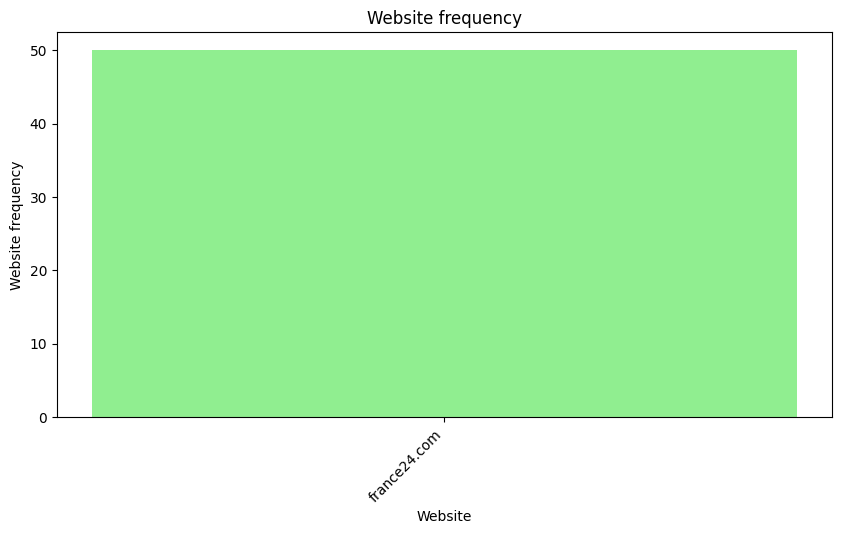

In [7]:
data_dict = dict(df['site'].value_counts())

colors = ['lightgreen', 'lightblue', 'pink', 'orange', 'grey']


plt.bar(data_dict.keys(), data_dict.values(), color=colors)
plt.title('Website frequency')
plt.xlabel('Website')
plt.ylabel('Website frequency')
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(10, 5)
#plt.savefig('plots/1_agg/website_frequency.png', bbox_inches='tight')


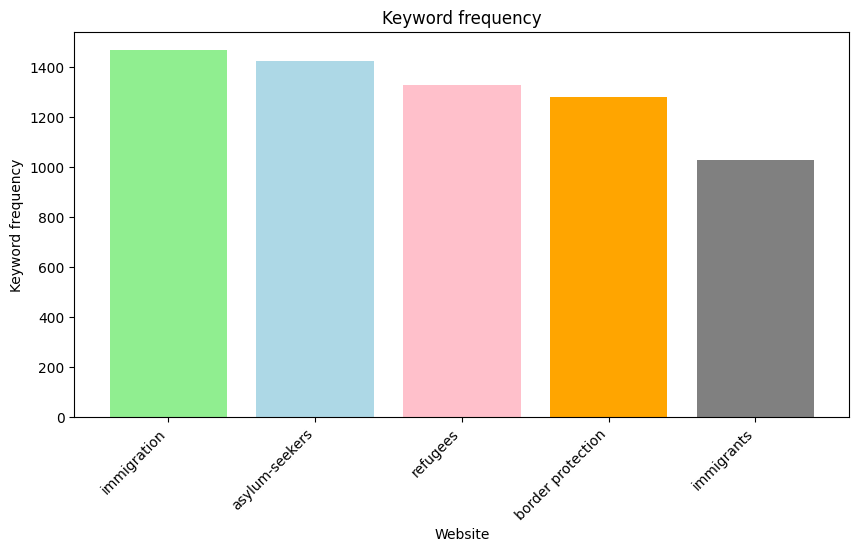

In [7]:
data_dict = dict(df['keyword'].value_counts())

colors = ['lightgreen', 'lightblue', 'pink', 'orange', 'grey', 'purple', 'darkgrey']


plt.bar(data_dict.keys(), data_dict.values(), color=colors)
plt.title('Keyword frequency')
plt.xlabel('Website')
plt.ylabel('Keyword frequency')
plt.xticks(rotation=45, ha='right')
plt.gcf().set_size_inches(10, 5)
#plt.savefig('plots/1_agg/keyword_frequency.png', bbox_inches='tight')



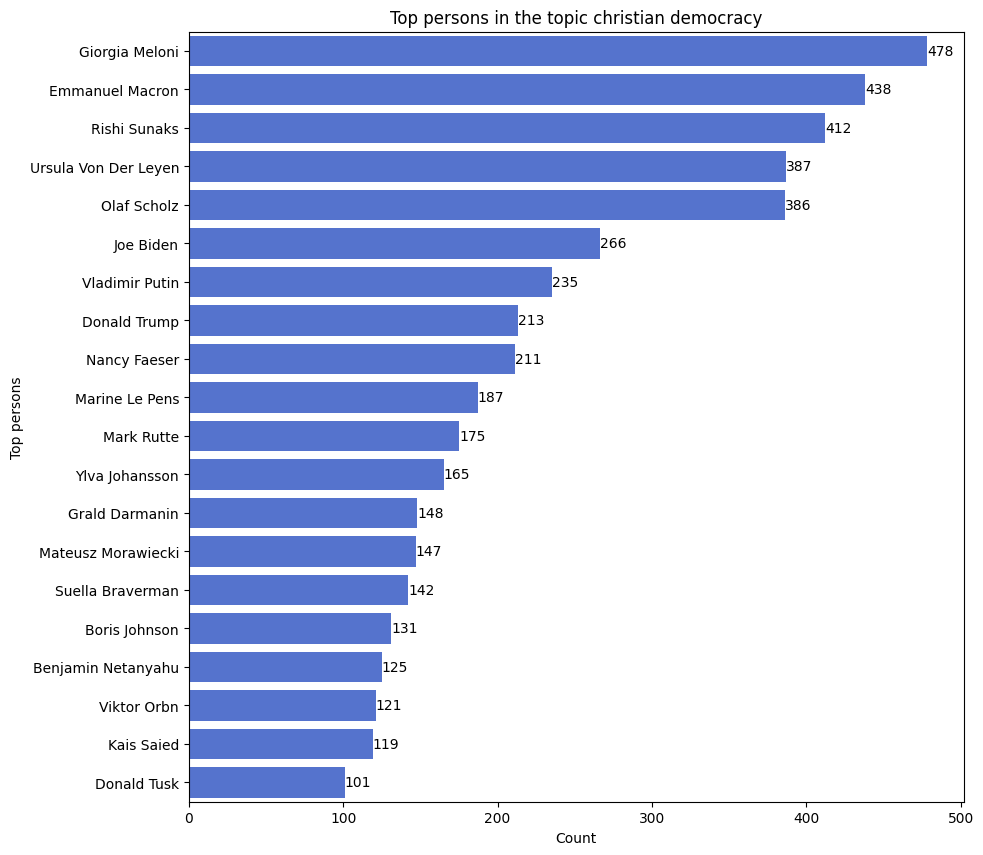

In [8]:
y_label = 'Top persons'
filename = 'plots/2_persons/top_persons.png'
top_persons = Counter([item for sublist in list(df['persons_ner_normalized_unique']) for item in sublist]).most_common()[0:20]

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
count_plot(top_persons, axes, "Top persons in the topic christian democracy", y_label, filename)


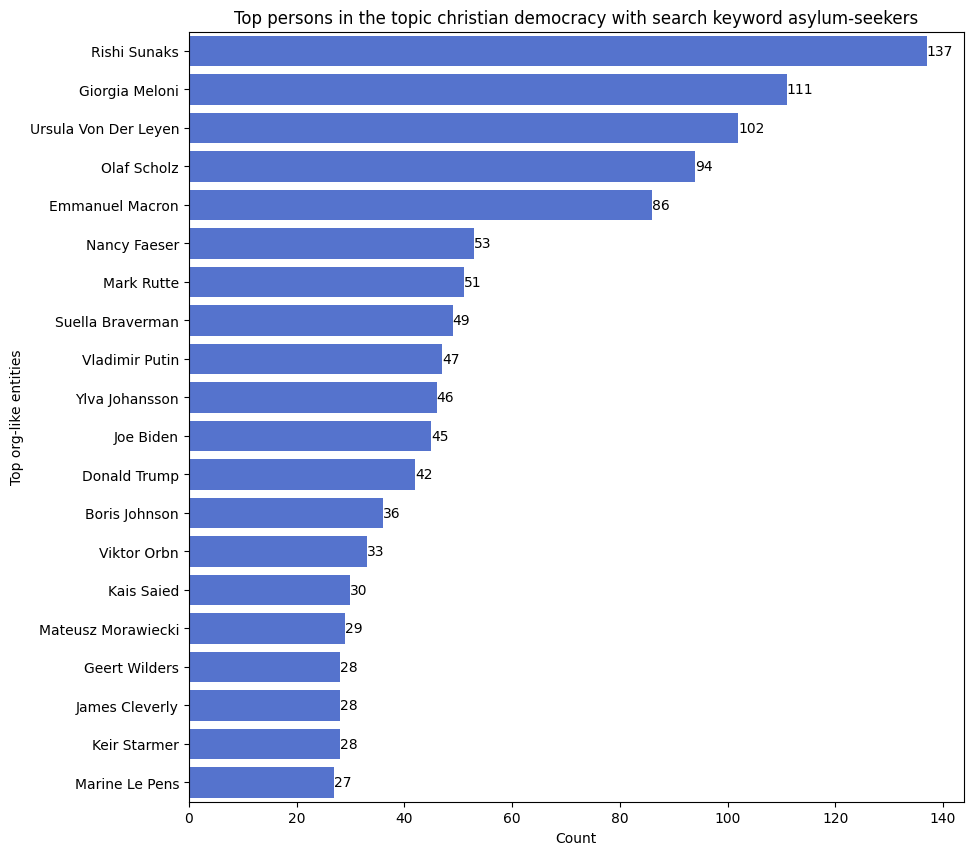

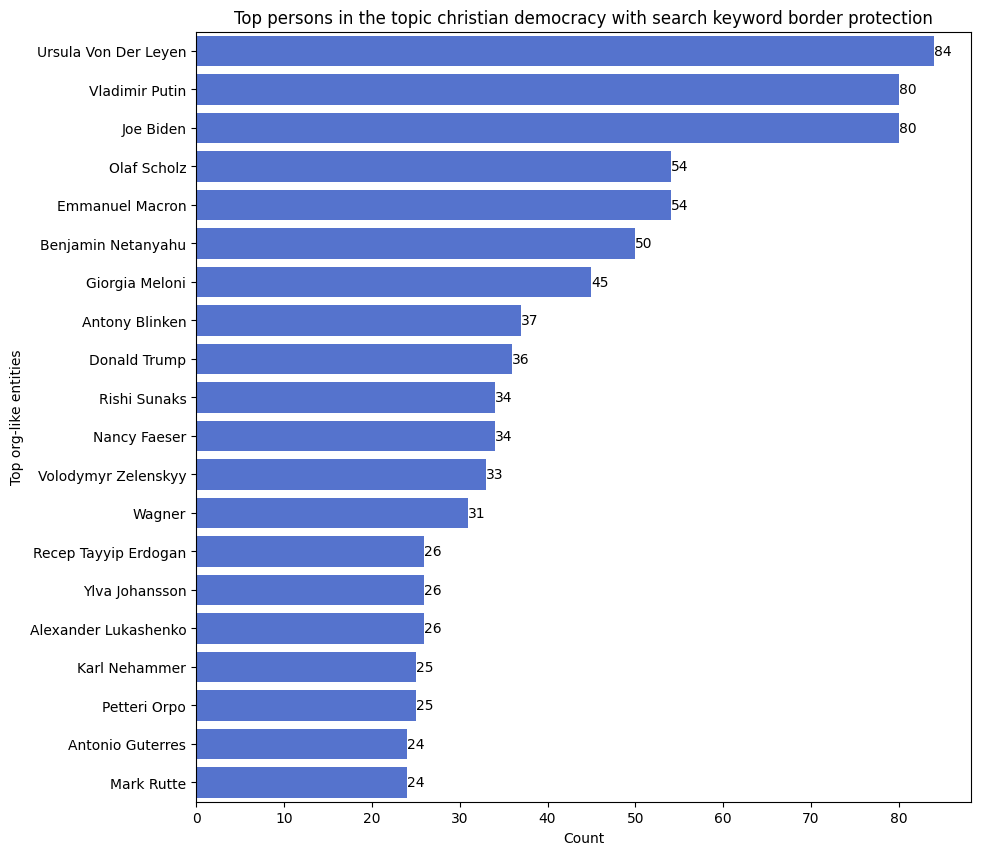

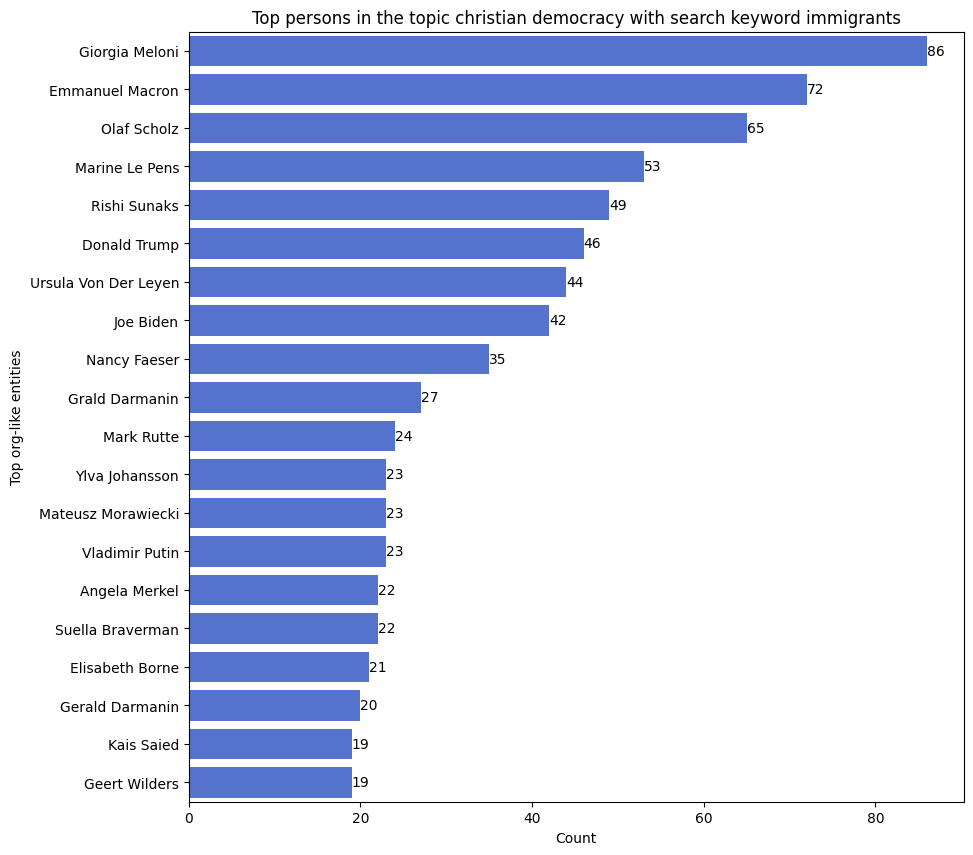

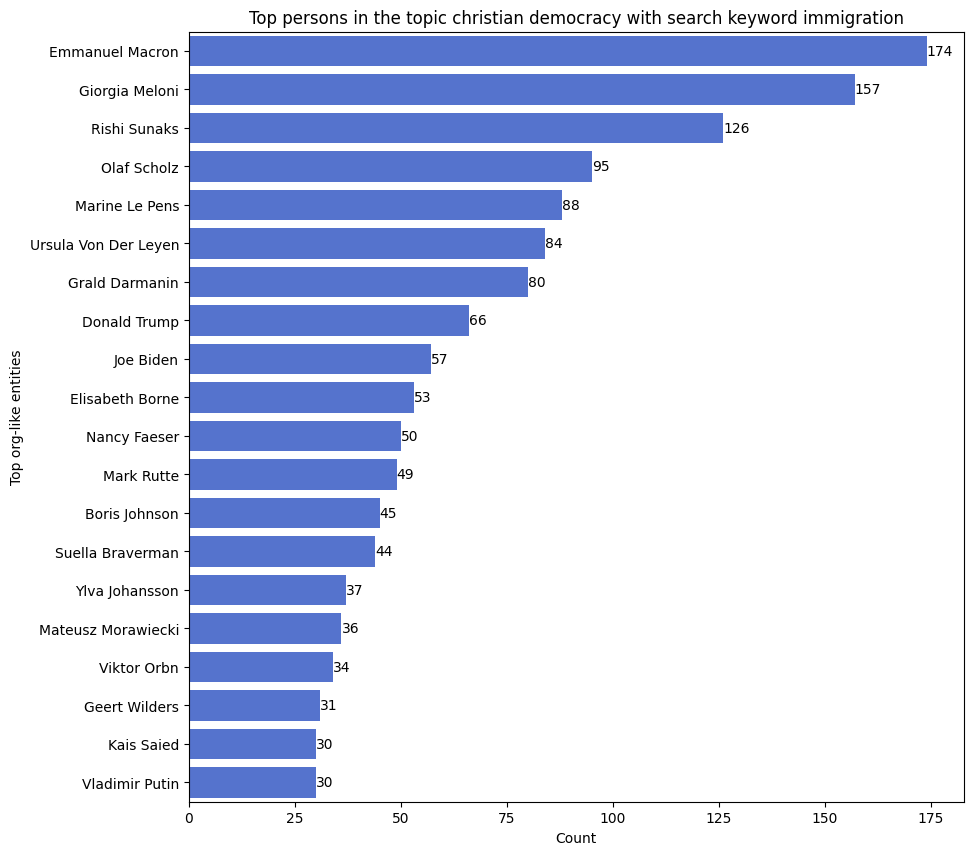

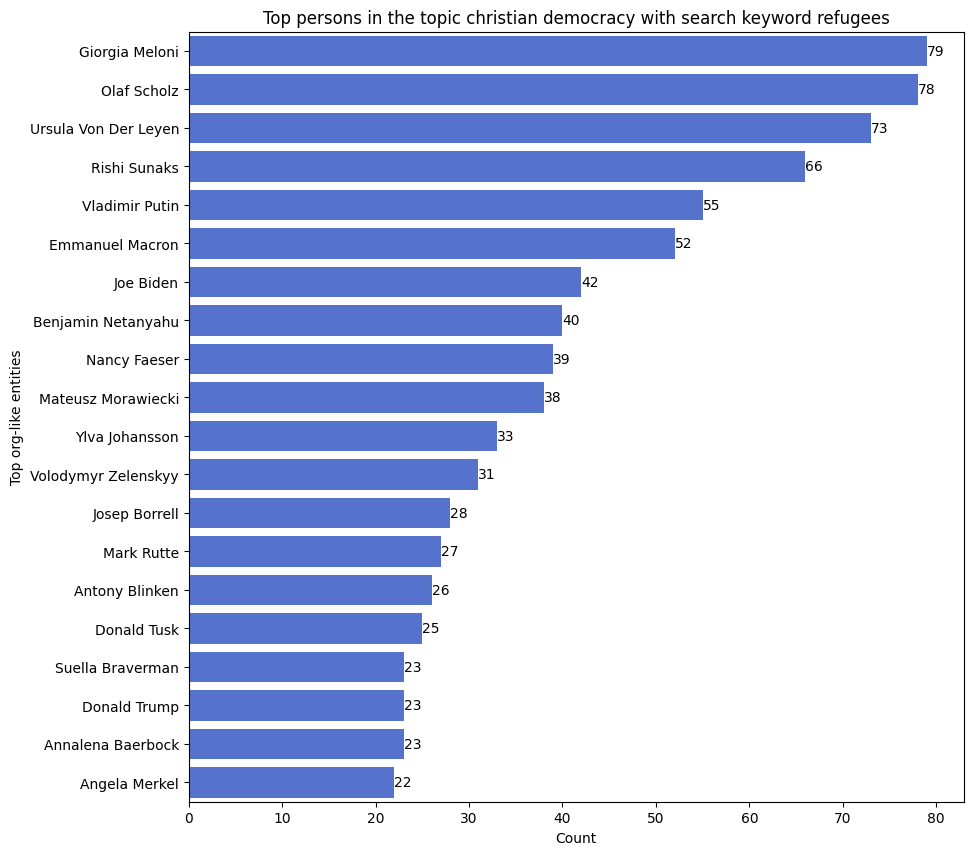

In [14]:
for i in range(df['keyword'].nunique()):
    
    keyword = list(df['keyword'].unique())[i]
    filename = f'plots/2_persons/top_persons_{keyword.lower()}.png'
    temp_df = df[df.keyword == keyword]
    top_persons = Counter([item for sublist in list(temp_df['persons_ner_normalized_unique']) for item in sublist]).most_common()[0:20]

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    count_plot(top_persons, axes, f"Top persons in the topic christian democracy with search keyword {keyword.lower()}", y_label, filename)


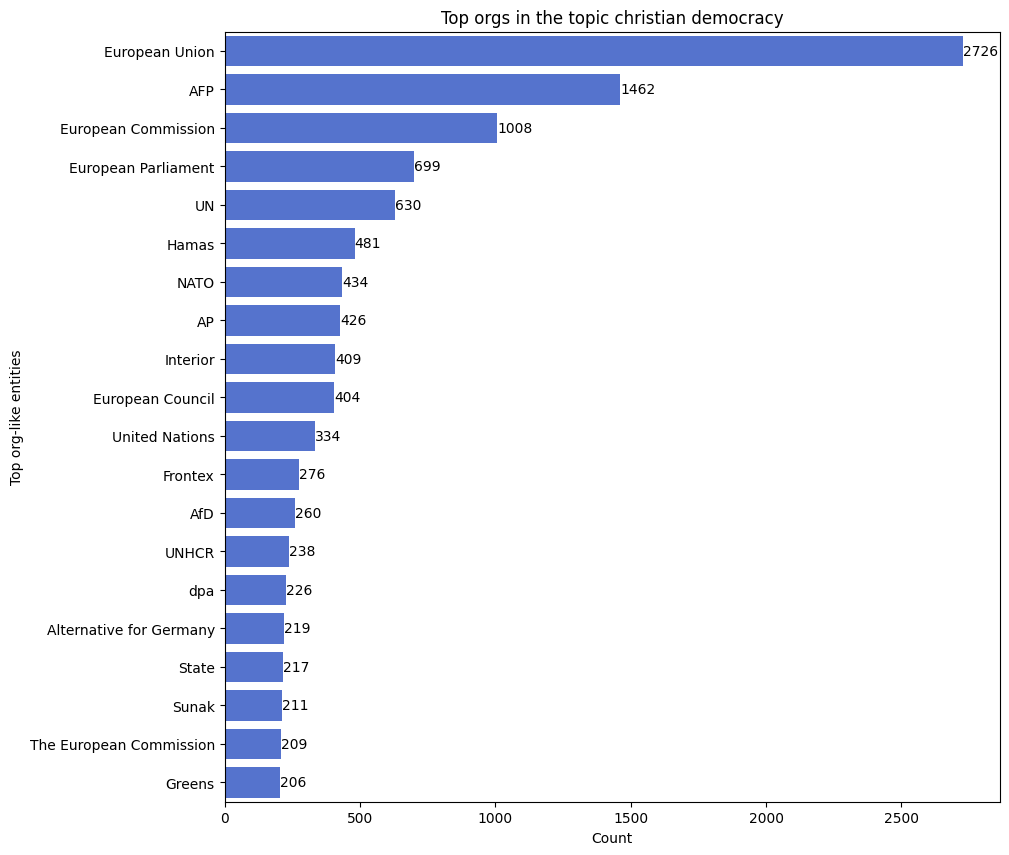

In [16]:
y_label = 'Top org-like entities'
filename = 'plots/3_orgs/top_entities.png'
top_entities = Counter([item for sublist in list(df['org_ner_unique']) for item in sublist]).most_common()[0:20]

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
count_plot(top_entities, axes, "Top orgs in the topic christian democracy", y_label, filename)


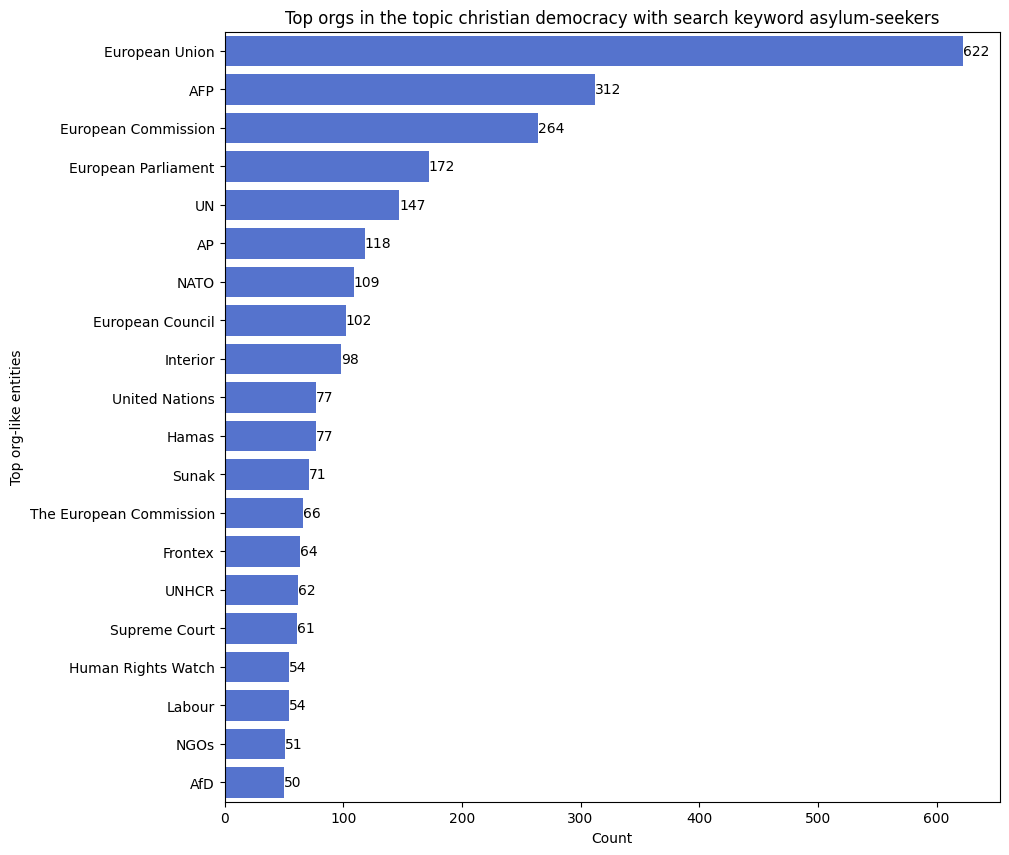

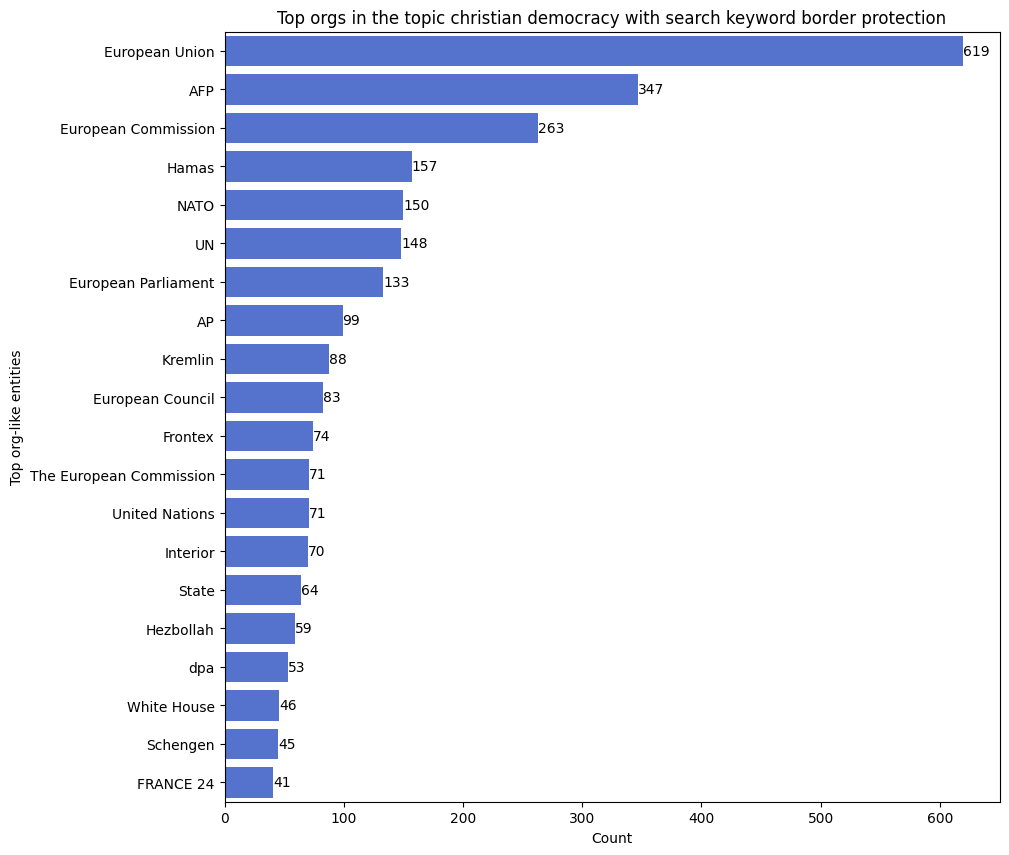

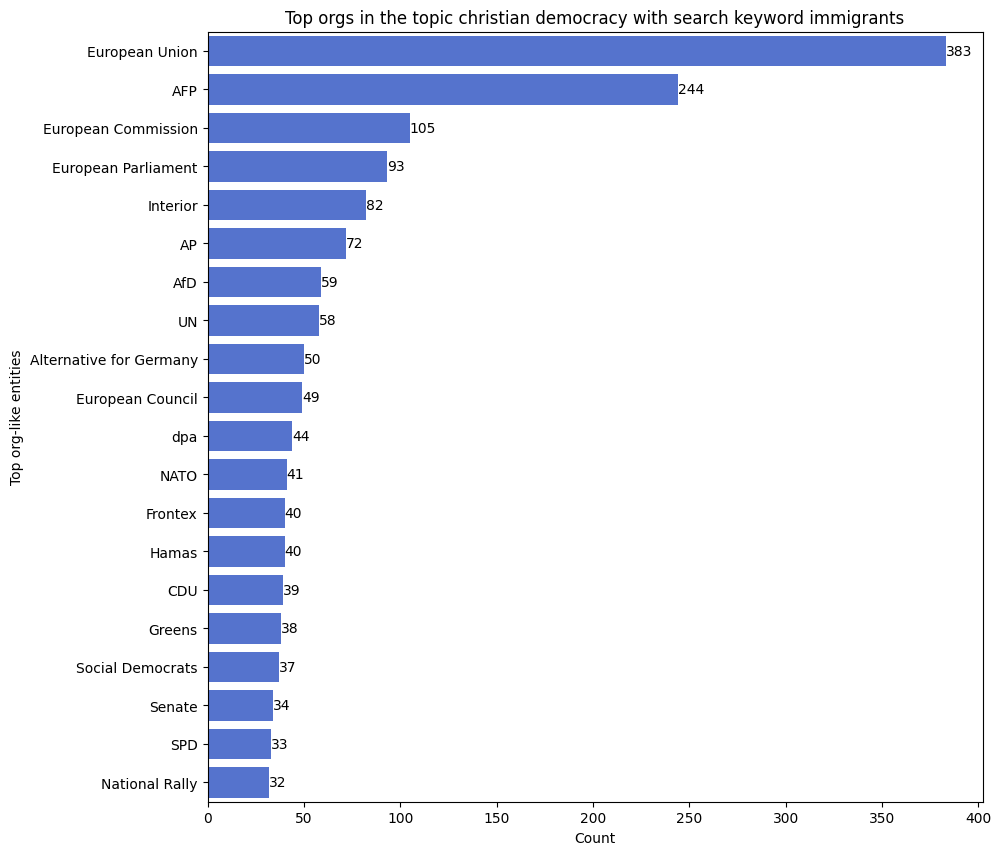

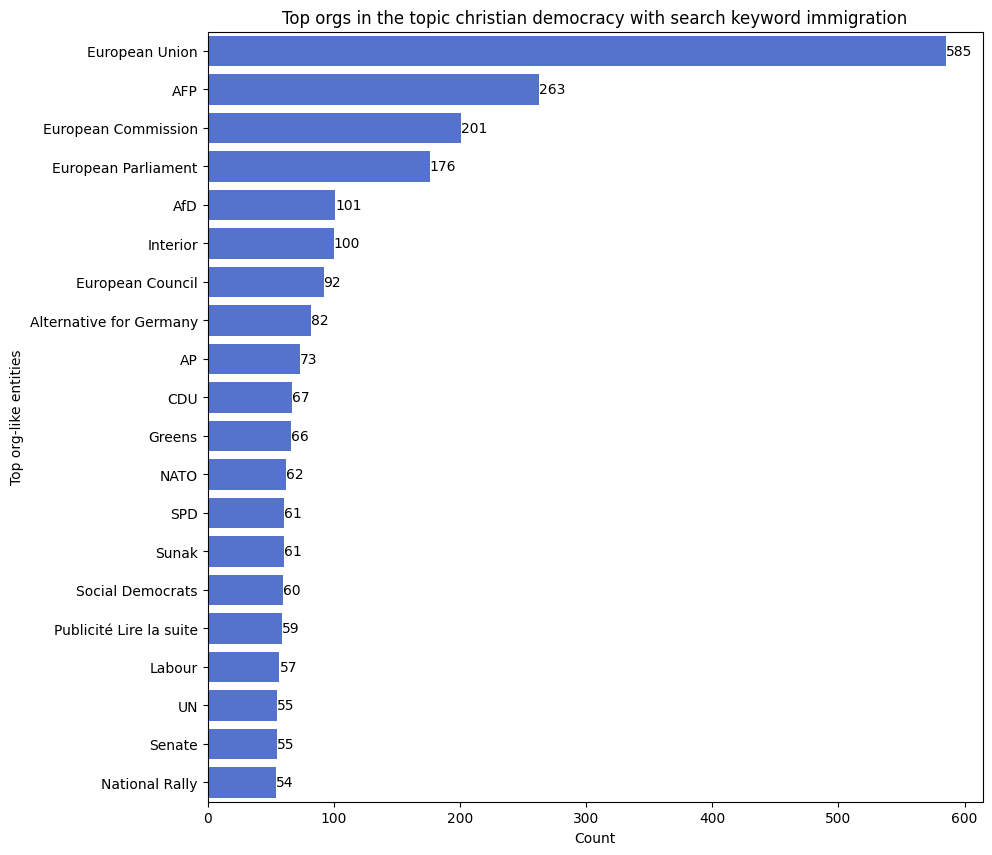

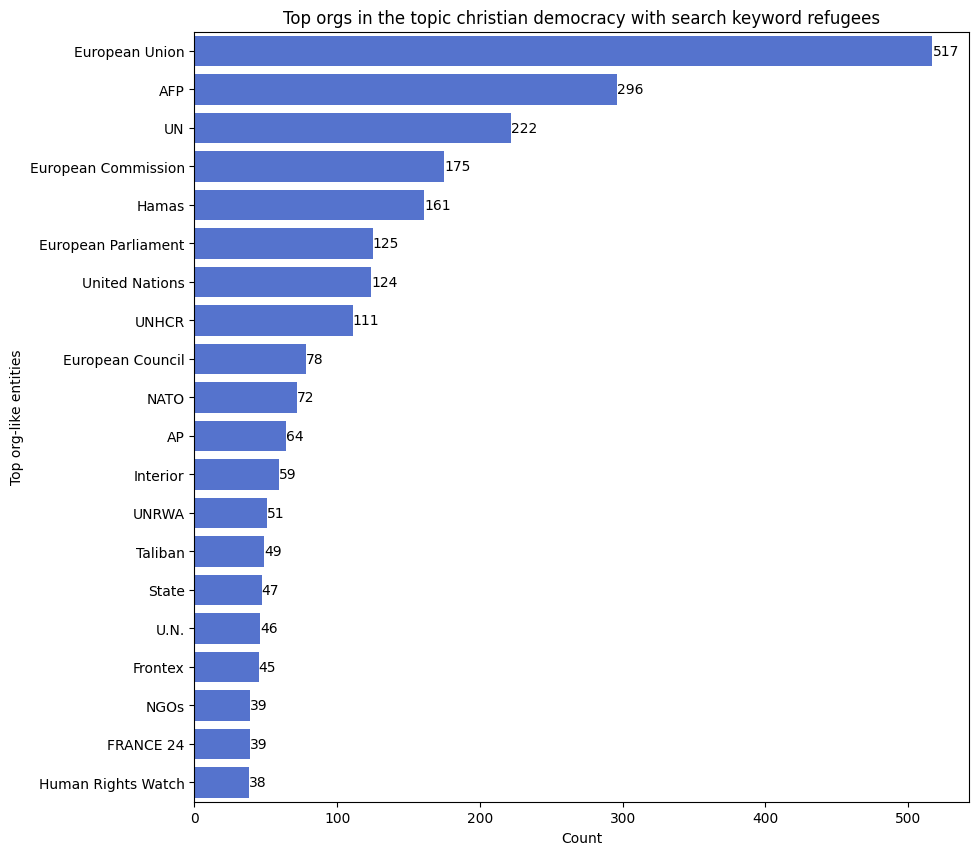

In [17]:
for i in range(df['keyword'].nunique()):
    
    keyword = list(df['keyword'].unique())[i]
    filename = f'plots/3_orgs/top_orgs_{keyword.lower()}.png'
    temp_df = df[df.keyword == keyword]
    top_persons = Counter([item for sublist in list(temp_df['org_ner_unique']) for item in sublist]).most_common()[0:20]

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    count_plot(top_persons, axes, f"Top orgs in the topic christian democracy with search keyword {keyword.lower()}", y_label, filename)


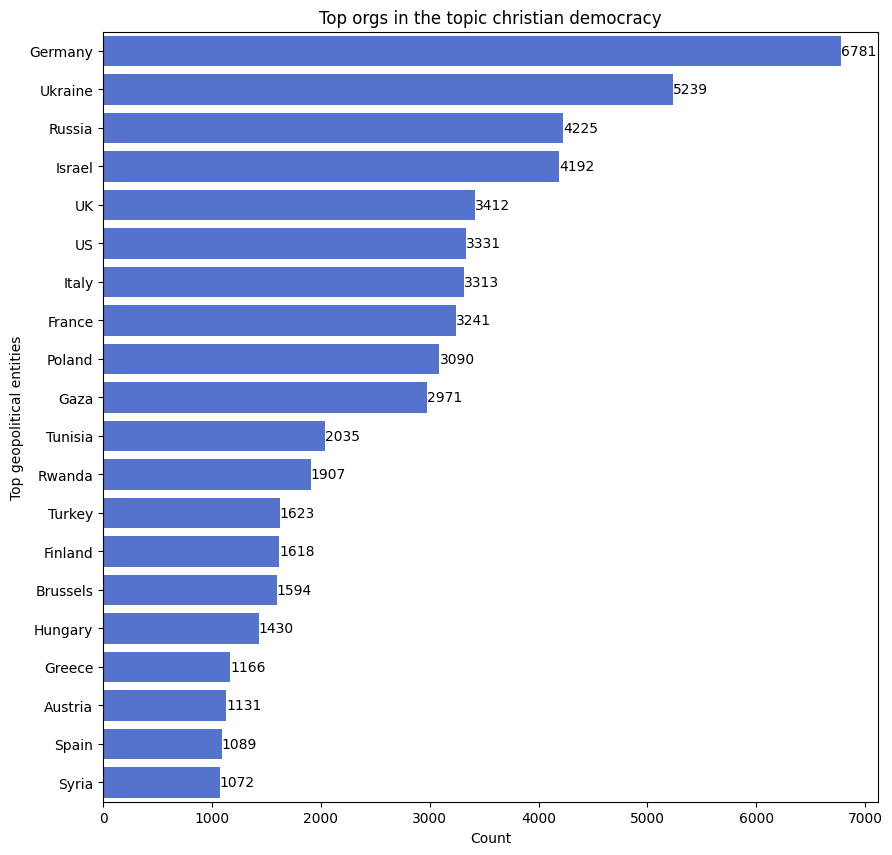

In [20]:
y_label = 'Top geopolitical entities'
filename = 'plots/4_gpe/entities.png'
top_entities = Counter([item.replace('.', '') for sublist in list(df['gpe_ner']) for item in sublist]).most_common()[0:20]

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
count_plot(top_entities, axes, "Top orgs in the topic christian democracy", y_label, filename)


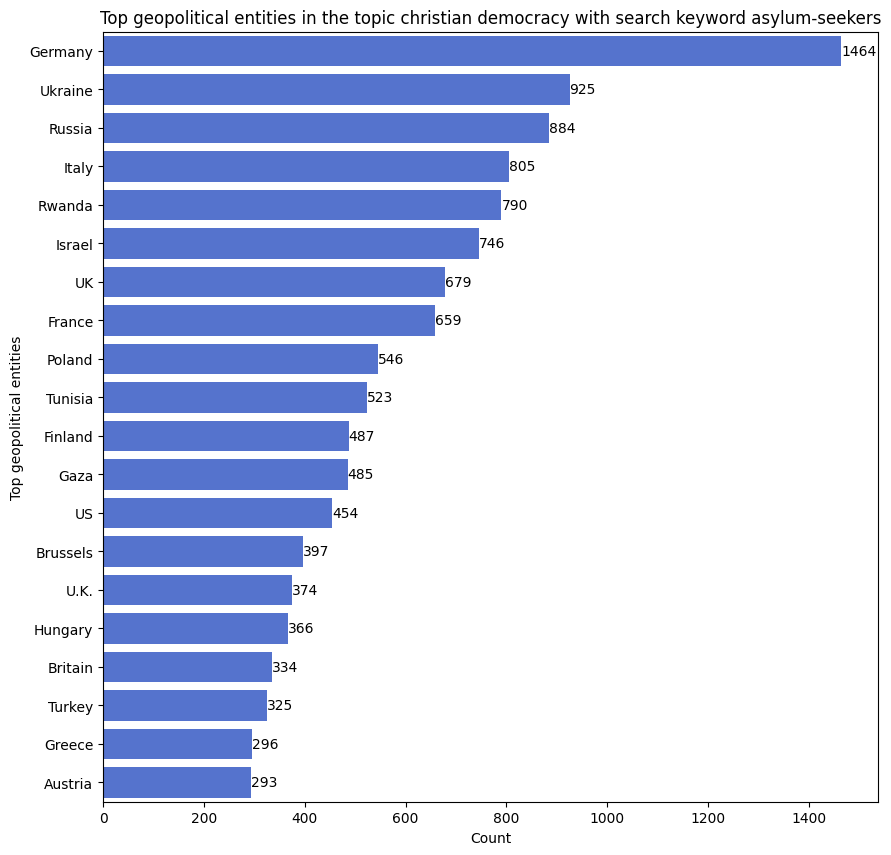

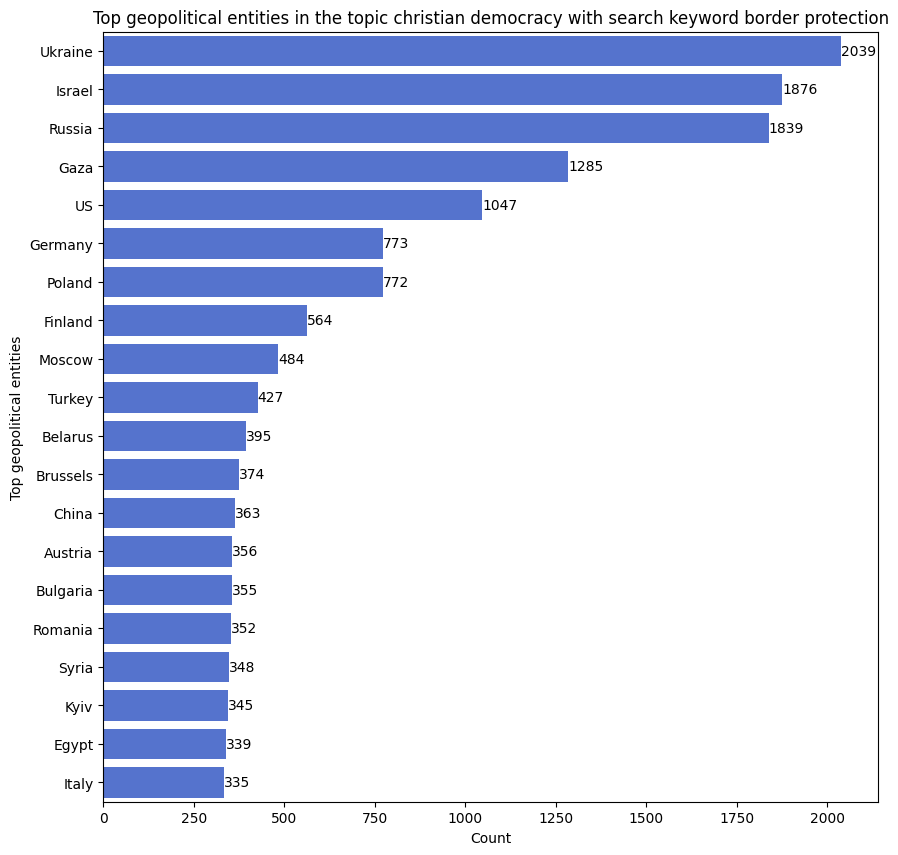

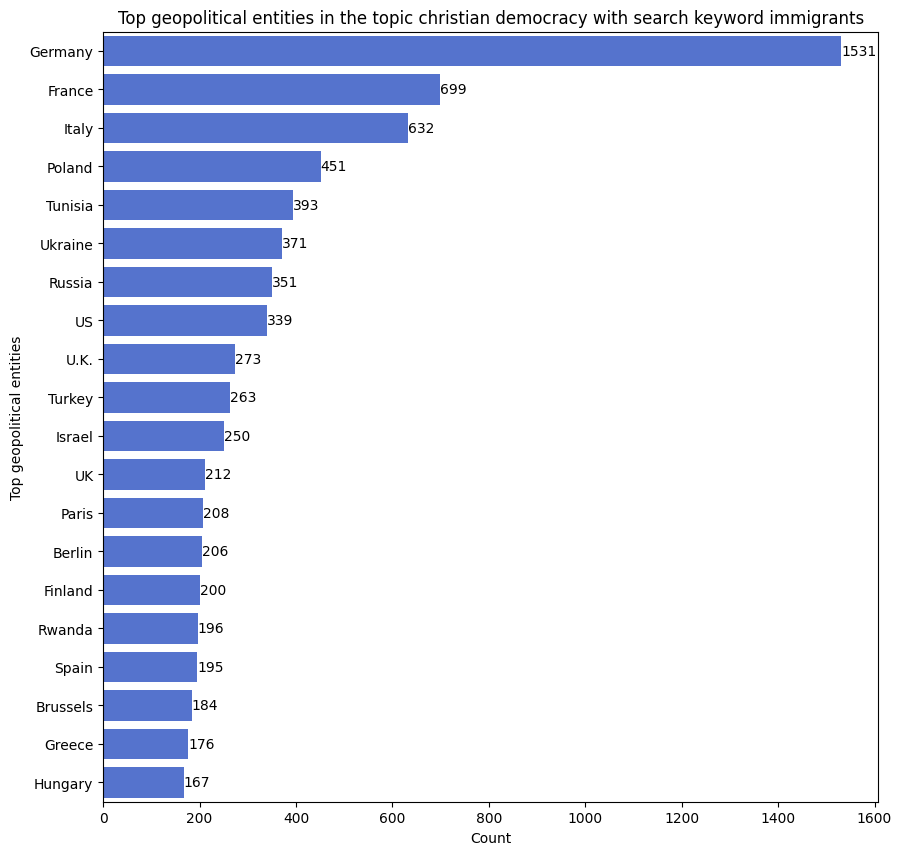

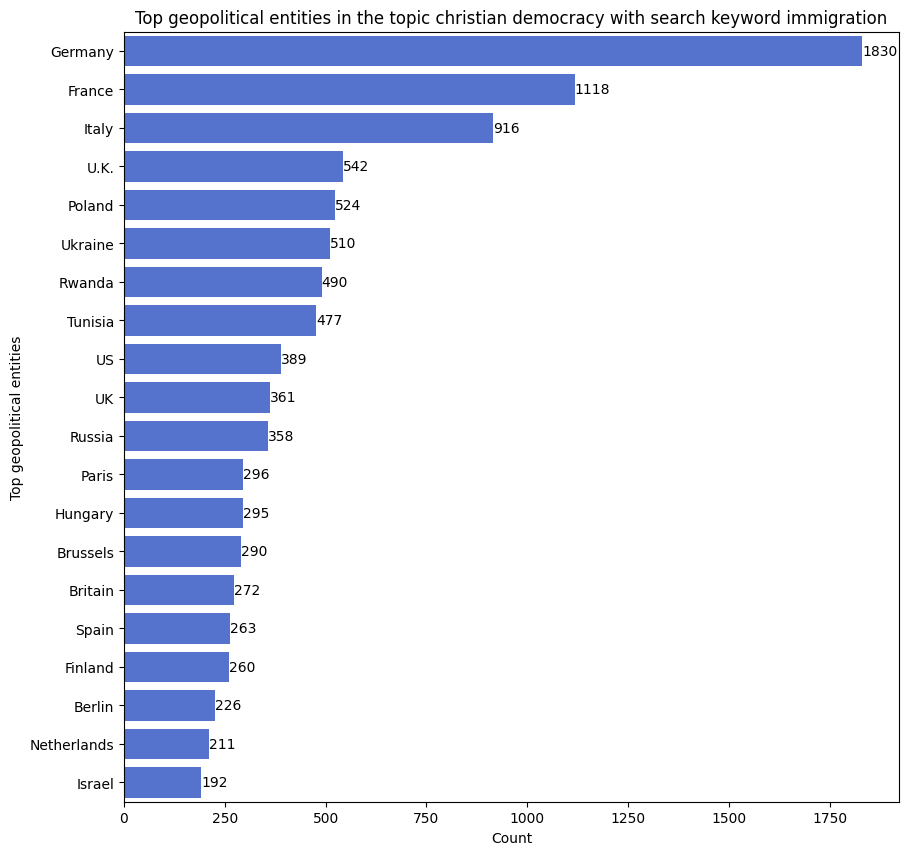

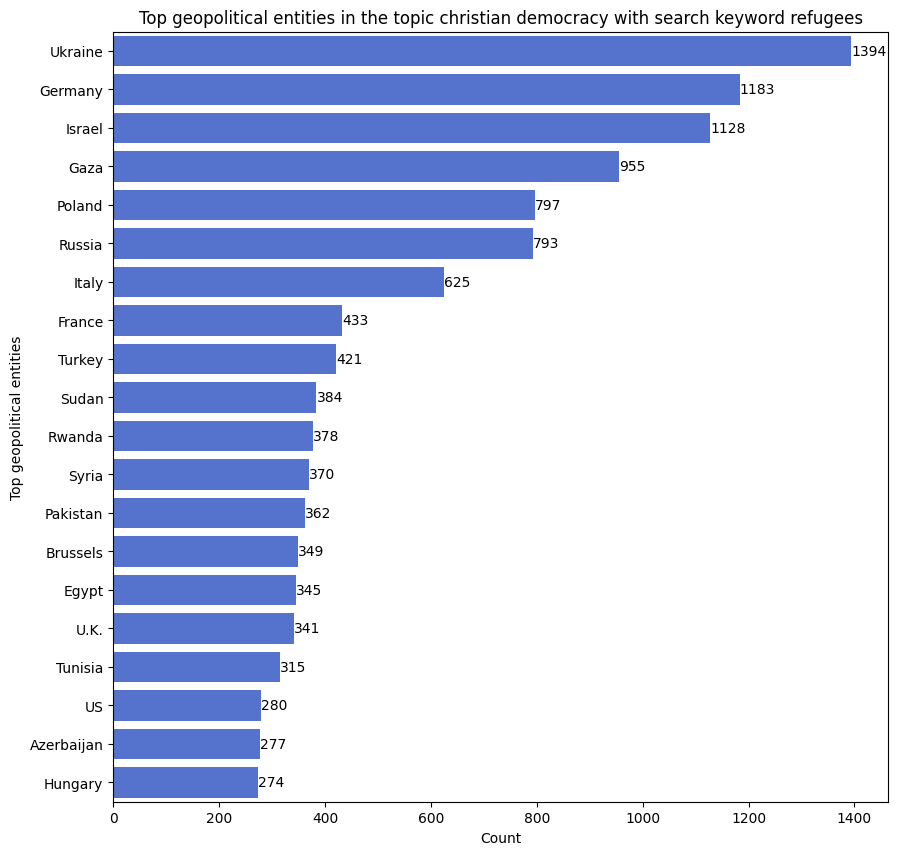

In [21]:
for i in range(df['keyword'].nunique()):
    
    keyword = list(df['keyword'].unique())[i]
    filename = f'plots/4_gpe/entities_{keyword.lower()}.png'
    temp_df = df[df.keyword == keyword]
    top_persons = Counter([item for sublist in list(temp_df['gpe_ner']) for item in sublist]).most_common()[0:20]

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    count_plot(top_persons, axes, f"Top geopolitical entities in the topic christian democracy with search keyword {keyword.lower()}", y_label, filename)


In [ ]:
for i in range(df['keyword'].nunique()):
    
    keyword = list(df['keyword'].unique())[i]
    filename = f'plots/5_events/entities_{keyword.lower()}.png'
    temp_df = df[df.keyword == keyword]
    top_persons = Counter([item for sublist in list(temp_df['gpe_ner']) for item in sublist]).most_common()[0:20]

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    count_plot(top_persons, axes, f"Top geopolitical entities in the topic christian democracy with search keyword {keyword.lower()}", y_label, filename)


# Create graphs 

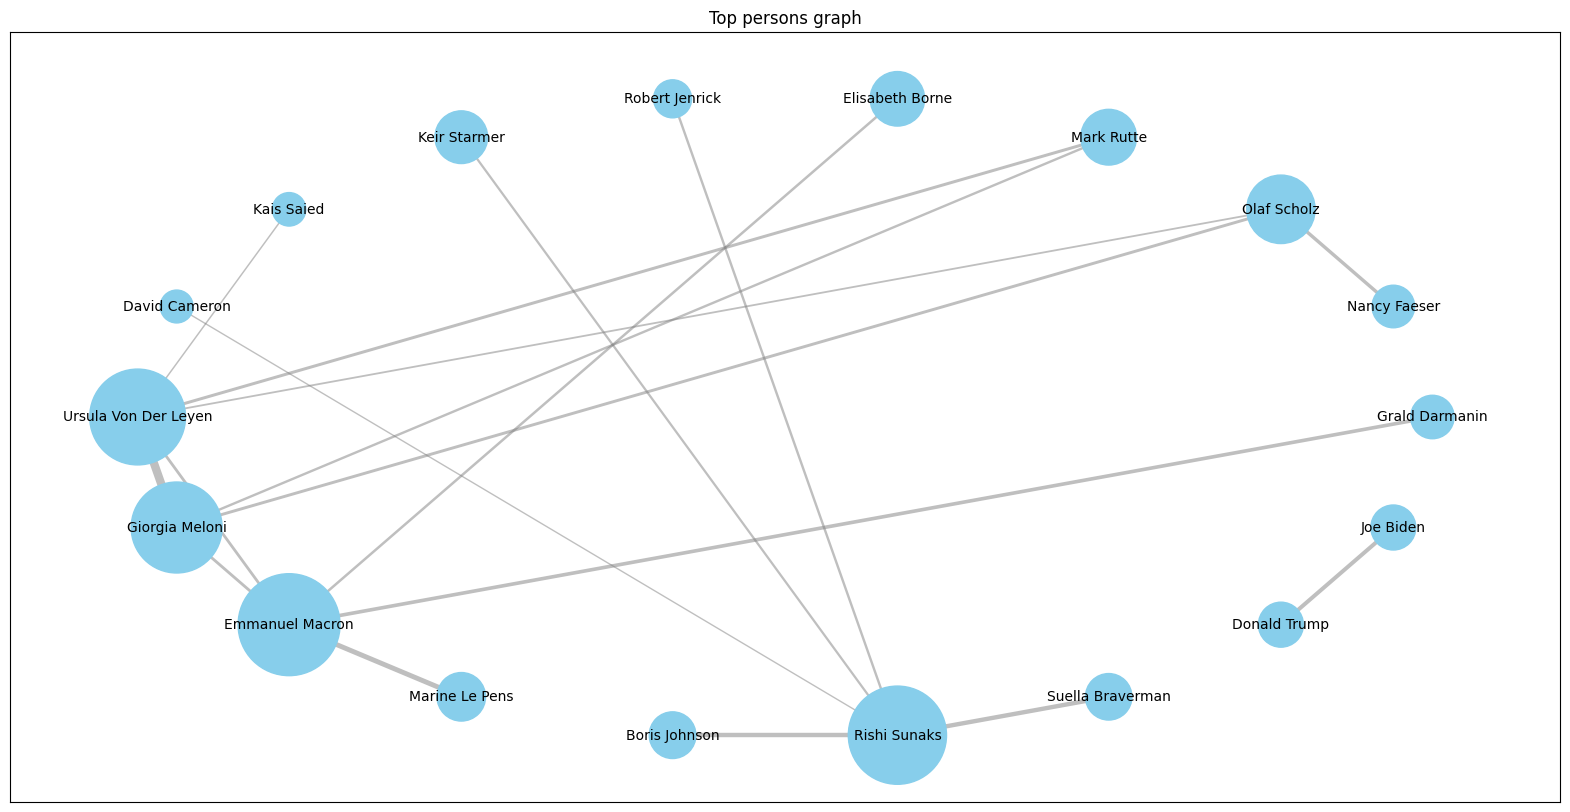

In [33]:
#occurrences = calc_occurrences(df)
occurrences = get_occurrences(df['persons_ner_normalized_unique'], df['persons_ner_normalized_unique'])
create_graph(occurrences, 'Top persons graph', 'plots/6_graphs/top_persons.png')

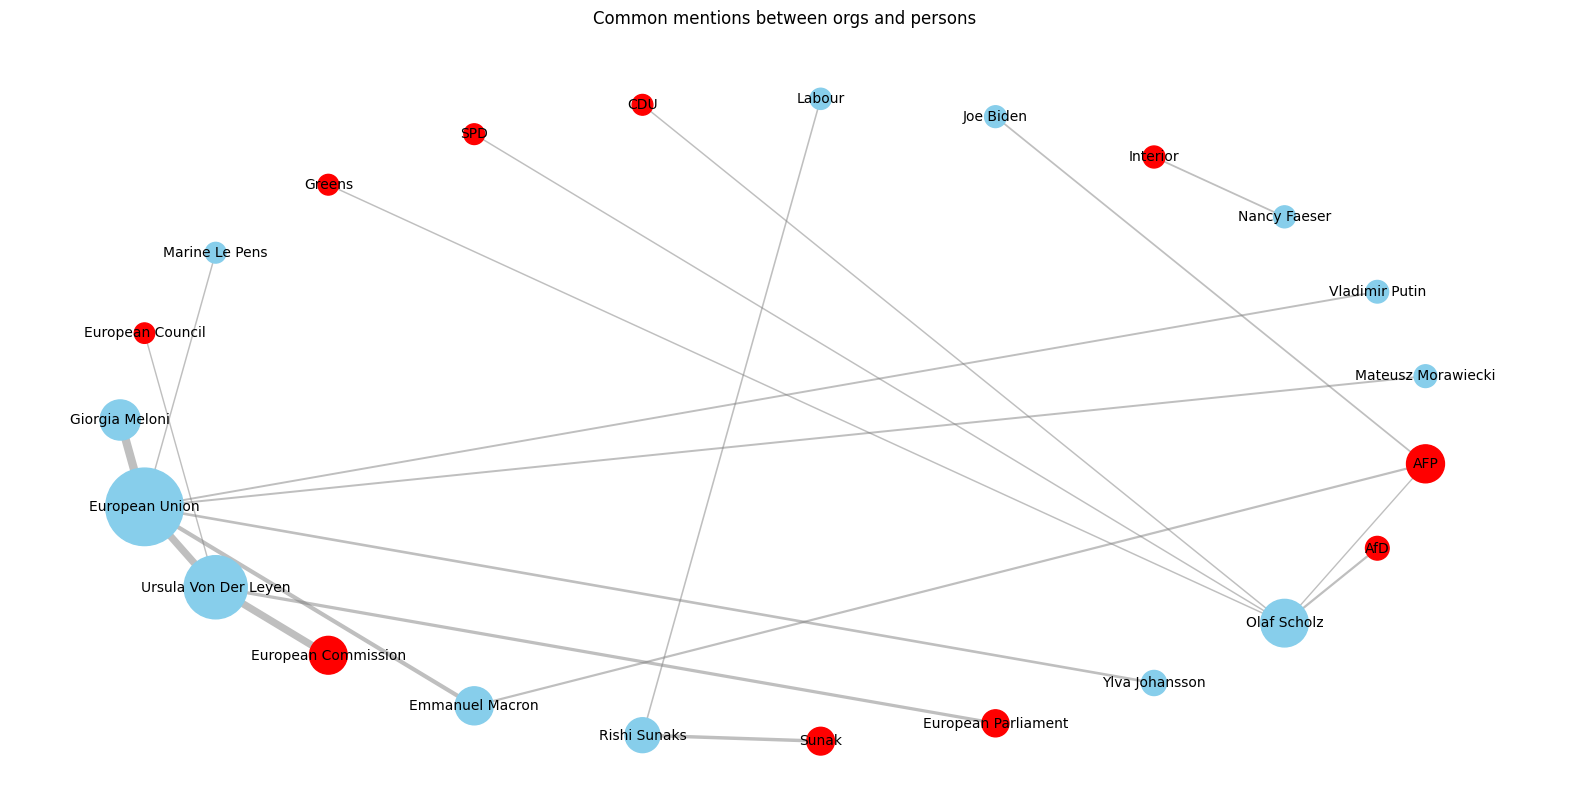

In [63]:
#occurrences = calc_occurrences(df)
occurrences = get_occurrences(df['persons_ner_normalized_unique'], df['org_ner_unique'])
persons = set([item for sublist in df['persons_ner_normalized_unique'] for item in sublist])
graph = create_graph_w_mixed_entity(occurrences, persons, 'Common mentions between orgs and persons', 'plots/6_graphs/orgs_persons.png')

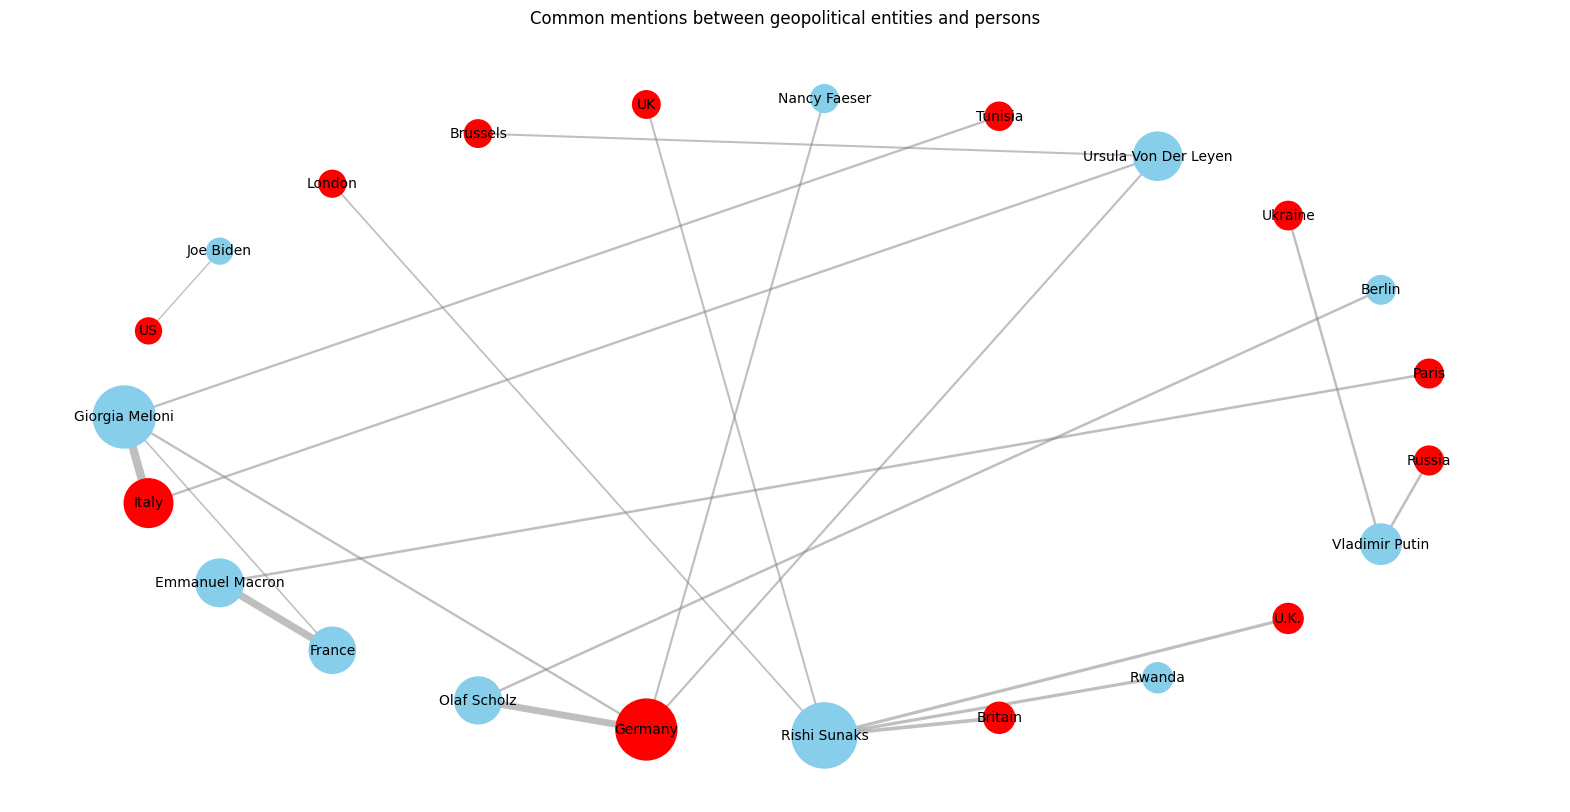

In [35]:
#occurrences = calc_occurrences(df)
occurrences = get_occurrences(df['persons_ner_normalized_unique'], df['gpe_ner'])
persons = set([item for sublist in df['persons_ner_normalized_unique'] for item in sublist])
create_graph_w_mixed_entity(occurrences, persons, 'Common mentions between geopolitical entities and persons', 'plots/6_graphs/gpe_persons.png')

In [68]:
from datetime import datetime

In [82]:
df['publish_date'].iloc[0].replace(day=1)

datetime.date(2023, 6, 1)

# Create time series

In [83]:
df = df[df.publish_date.apply(lambda x: str(x.year) == '2023' )]
df['Month_Level'] = df['publish_date'].apply(lambda x: x.replace(day=1))
df['Month_Level'] = df.Month_Level.apply(lambda x: str(x))
#or str(x.year) == '2024'

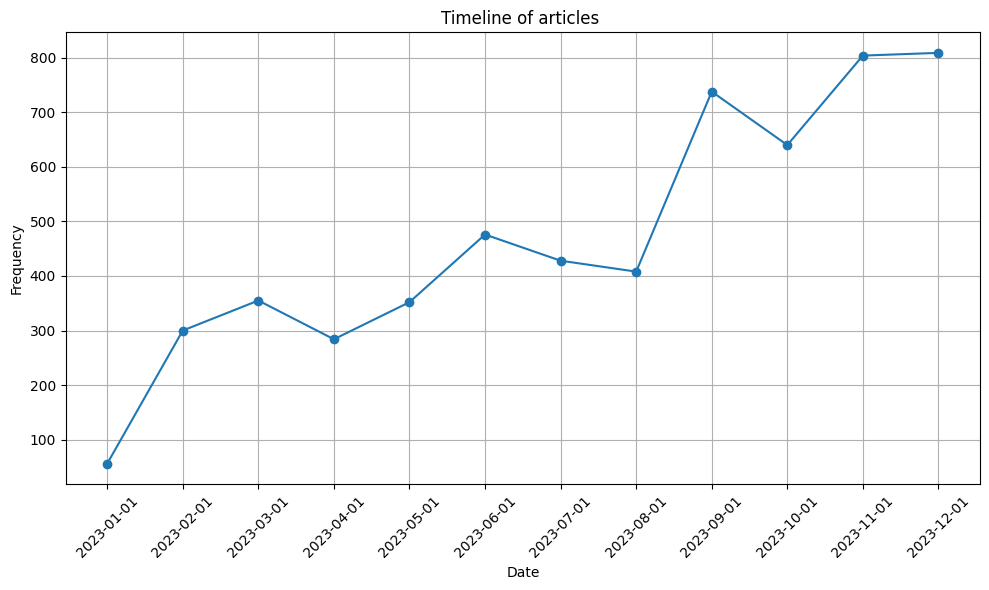

<Figure size 640x480 with 0 Axes>

In [87]:
# Count frequency of events by date
event_count = df['Month_Level'].value_counts().sort_index()

# Create the timeline plot
plt.figure(figsize=(10, 6))
plt.plot(event_count.index, event_count.values, marker='o', linestyle='-')

# Format the plot
plt.title(f'Timeline of articles ')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()
plt.savefig('plots/7_timeseries/timeseries.png', bbox_inches='tight')

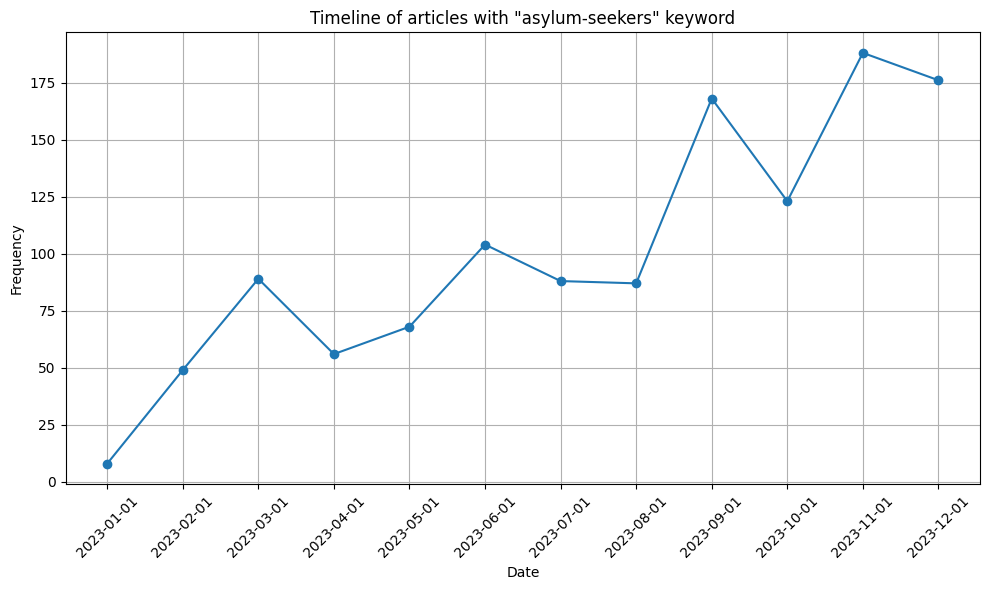

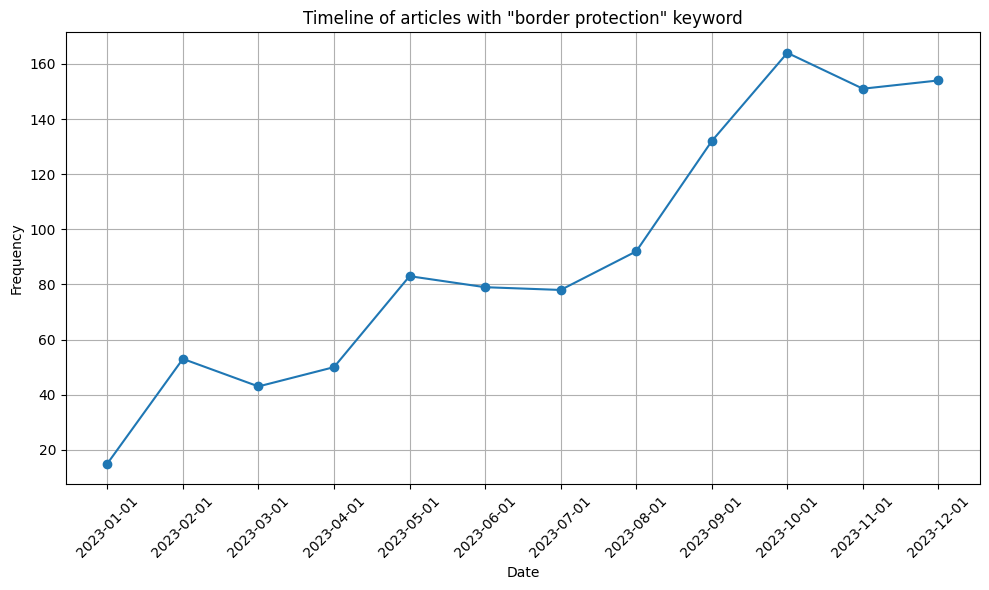

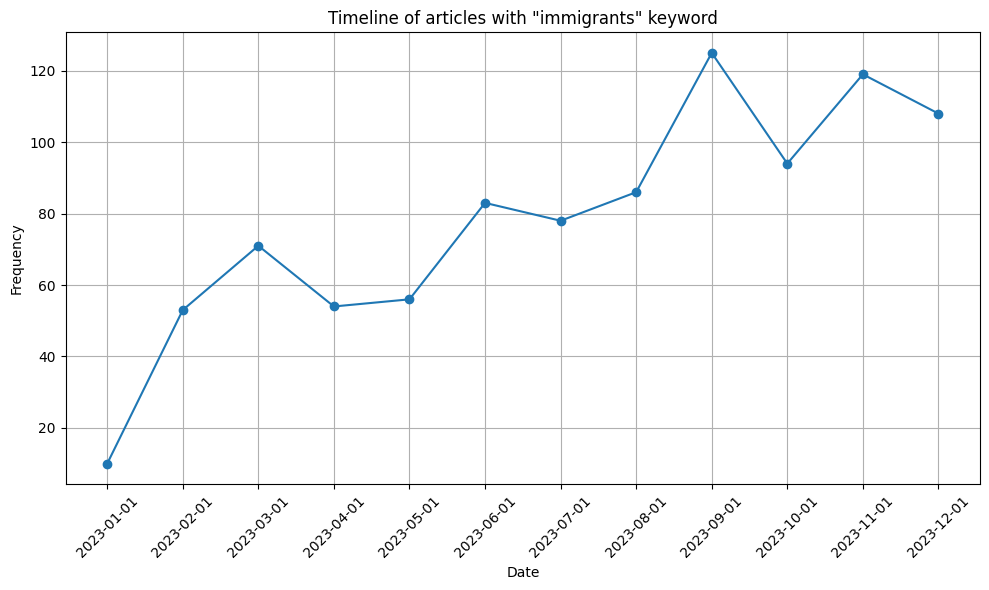

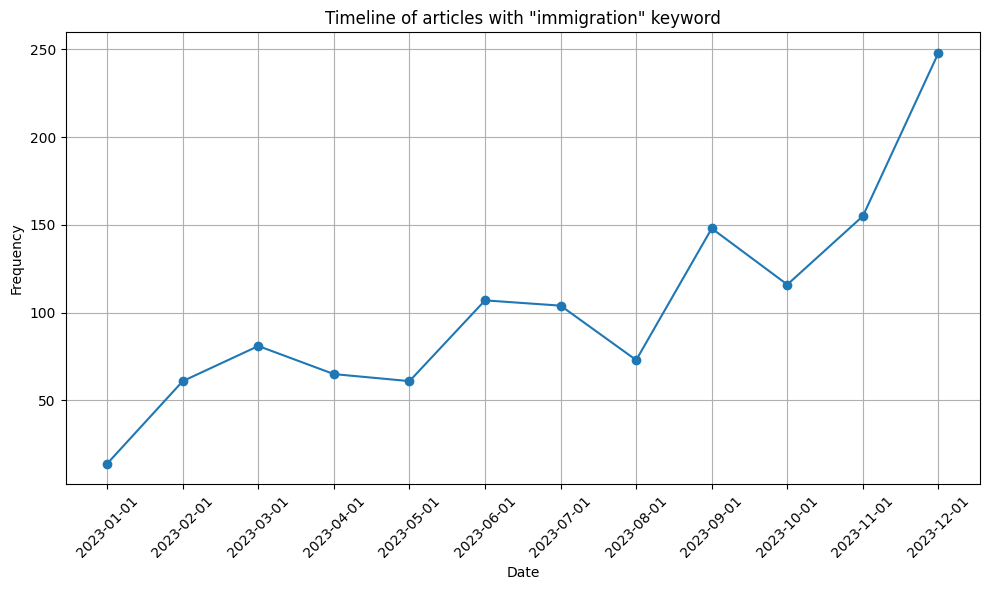

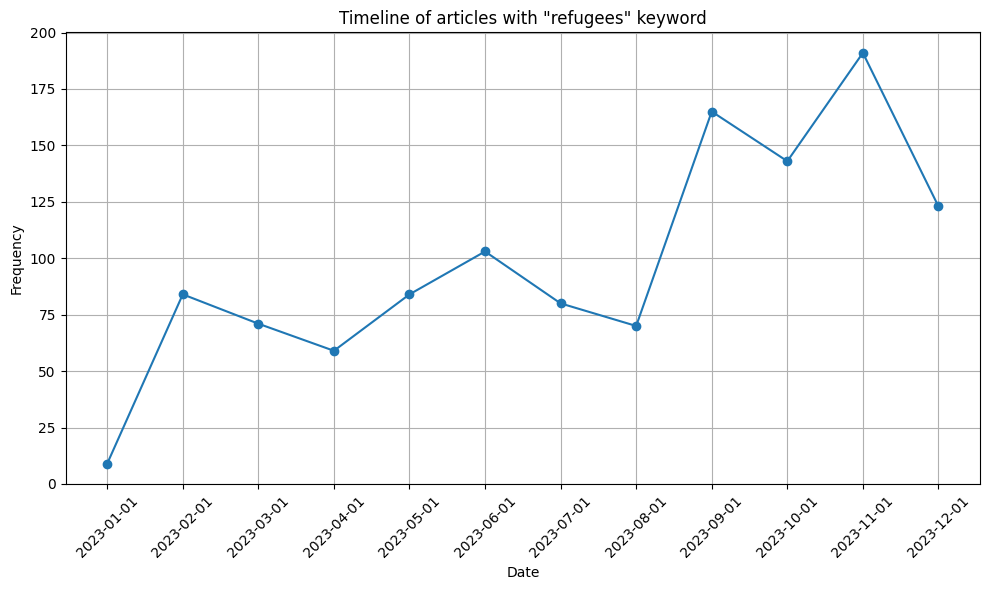

In [89]:
for keyword in df['keyword'].unique():
    temp_df = df[df.keyword == keyword]
    # Sort DataFrame by date
    temp_df = temp_df.sort_values('Month_Level')

    # Count frequency of events by date
    event_count = temp_df['Month_Level'].value_counts().sort_index()

    # Create the timeline plot
    plt.figure(figsize=(10, 6))
    plt.plot(event_count.index, event_count.values, marker='o', linestyle='-')

    # Format the plot
    plt.title(f'Timeline of articles with "{keyword}" keyword')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'plots/7_timeseries/timeseries_{keyword}.png', bbox_inches='tight')
    # Display the plot
    plt.show()

In [90]:
TITLE = "immigrants_output.pdf"

png_files = glob.glob('plots/**/*.png', recursive=True)

images = []

for filename in tqdm(png_files):
    images.append(Image.open(filename))

images[0].save(TITLE, save_all=True, append_images=images[1:])


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 62.11it/s]


## WARNING

# Bencze Tomi része, itt kezdődik Mordor

In [93]:

df_parag = pd.read_parquet('data/immigrants_processed_file.parquet')
df_parag = df_parag[df_parag['entities'].notna()]
df_parag['polarity_score'] = df_parag.apply(lambda row: 0 if row['sentiment'] == 'neutral' else -row['score'] if row['sentiment'] == 'negative' else row['score'], axis=1)

In [94]:
def replace_eu(lst):
    return ['European Union' if item == 'EU' else item for item in lst]


df_parag['gpe_ner'] = df_parag.entities.apply(lambda entity_list: [x[0] for x in entity_list if x[1] == 'GPE' ])
df_parag['org_ner'] = df_parag.entities.apply(lambda entity_list: [x[0] for x in entity_list if x[1] == 'ORG' ])
df_parag['persons_ner'] = df_parag.entities.apply(lambda entity_list: [x[0] for x in entity_list if x[1] == 'PERSON' ])
df_parag['org_ner'] = df_parag['org_ner'].apply(lambda x: replace_eu(x))
df_parag['gpe_ner_unique'] = df_parag['gpe_ner'].apply(lambda x: set(x))
df_parag['org_ner_unique'] = df_parag['org_ner'].apply(lambda x: set(x))

#df_parag['persons_ner'] = df_parag['persons_ner'].apply(lambda x: x[:-3] if len(x)>3 else [])

In [95]:
df_parag.rename(columns={'split_text': 'text'}, inplace=True)

In [96]:
df_parag['event_ner'] = df_parag.entities.apply(lambda entity_list: [x[0] for x in entity_list if x[1] == 'EVENT' ])

df_parag['summit'] = df_parag['text'].apply(lambda x: (' summit ' in x.lower()) or (' summit,' in x.lower()) or (' summit.' in x.lower()))
df_parag['council_meeting'] = df_parag['text'].apply(lambda x: (' council meeting ' in x.lower()) or (' council meeting,' in x.lower()) or (' council meeting.' in x.lower()))

def update_event_ner(row):
    event_ner = row['event_ner']
    if row['summit']:
        event_ner.append('Summit')
    if row['council_meeting']:
        event_ner.append('Council meeting')
    return event_ner

df_parag['event_ner'] = df_parag.apply(update_event_ner, axis=1)

df_parag['event_ner_unique'] = df_parag['event_ner'].apply(lambda x: set(x))

In [101]:
def replace_eu(lst):
    return [item.replace('EU', 'European Union') for item in lst]

org_norm_lst = ['European Commission','European Parliament','European Union', 'Green Deal']
replace_dict = {}
for org_list in tqdm(df_parag['org_ner']):
    for org in org_list:
        for org_norm in org_norm_lst:
            similarity = fuzz.token_set_ratio(org, org_norm)
            if similarity == 100:
                replace_dict[org] = org_norm
                
def replace_with_dict(lst):
    return [replace_dict.get(item, item) if item in replace_dict else item for item in lst]

df_parag['org_ner_norm'] = df_parag['org_ner'].progress_apply(replace_with_dict)

100%|██████████████████████████████████████████████████████████████████████████| 6530/6530 [00:00<00:00, 153733.23it/s]


In [102]:
df_parag['org_ner_norm_unique'] = df_parag['org_ner_norm'].apply(lambda x: set(x))

In [105]:
df_parag = df_parag[df_parag['polarity_score'].notna()]

KeyError: 'polarity_score'

In [106]:
df_parag

,keyword,site,url,publish_date,text,entities,gpe_ner,org_ner,org_ner_unique,persons_ner,event_ner,summit,council_meeting,event_ner_unique,org_ner_norm,persons_ner_normalized,persons_ner_normalized_unique,org_ner_norm_unique,gpe_ner_unique
0,asylum-seekers,dw.com,https://amp.dw.com/en/g%C3%BCzide-alcu-when-ku...,2023-06-03,"06/03/2023 June 3, 2023 Güzide Alcu ist the fa...","[[06/03/2023 June 3, 2023, DATE], [Güzide Alcu...",[],[Amedspor],{Amedspor},"[Güzide Alcu, Güzide]",[],False,False,{},[Amedspor],[],[],{Amedspor},{}
1,asylum-seekers,dw.com,https://learngerman.dw.com/en/german-news-serv...,2023-06-15,Family Minister Lisa Paus (Green Party) announ...,"[[Lisa Paus, PERSON], [Green Party, ORG], [Jan...","[the United States, US, US, Germany, Germany, ...","[Green Party, ZDF, Planned Parenthood, EuroPro...","{Planned Parenthood, the European Parliament, ...","[Lisa Paus, Paus, Paus, Paus, Lisa Paus, Carst...",[March for Life],False,False,{March for Life},"[Green Party, ZDF, Planned Parenthood, EuroPro...","[Lisa Paus, Paus, Paus, Paus, Lisa Paus, Carst...","[Gabie Raven, Terrisa Bukovinac, Ulli Jentsch,...","{Planned Parenthood, apabiz, DW, -, ZDF, the P...","{Netherlands, Pforzheim, Holland, Berlin, Hess..."
2,asylum-seekers,dw.com,https://learngerman.dw.com/en/migration/s-5812...,2024-01-02,The number of asylum applications to the Europ...,"[[the European Union, ORG], [the past two year...","[Berlin, EU, Tunisia, Tunisia, Turkey, Libya, ...","[the European Union, the European Union Agency...","{the European Union, the European Council, Par...","[Angela Merkel, Catherine Woollard, Woollard, ...",[],False,False,{},"[European Union, European Union, European Unio...","[Angela Merkel, Catherine Woollard, Woollard, ...","[Woollard, Catherine Woollard, Angela Merkel, ...","{the European Council, Party for Freedom, Euro...","{Turkey, Libya, Netherlands, Egypt, Brussels, ..."
3,asylum-seekers,dw.com,https://www.dw.com/en/150-people-injured-as-ri...,2023-09-03,"Alyona Murashova 09/03/2023 September 3, 2023 ...","[[Alyona Murashova, PERSON], [09/03/2023 Septe...",[Tel Aviv],[the Eritrean Embassy],{the Eritrean Embassy},[Alyona Murashova],[],False,False,{},[the Eritrean Embassy],[],[],{the Eritrean Embassy},{Tel Aviv}
4,asylum-seekers,dw.com,https://www.dw.com/en/42-doku-trailer/video-65...,2023-04-06,"To view this video please enable JavaScript, a...",[],[],[],{},[],[],False,False,{},[],[],[],{},{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6525,refugees,politico.eu,https://www.politico.eu/tag/medicines/,2024-01-22,The plan is to allow Gazans access to big volu...,"[[Gazans, NORP], [Egypt, GPE]]",[Egypt],[],{},[],[],False,False,{},[],[],[],{},{Egypt}
6526,refugees,politico.eu,https://www.politico.eu/tag/migration/,2024-01-25,The prime minister (finally) bumped up compens...,"[[Labour, ORG], [Keir Starmer, PERSON]]",[],[Labour],{Labour},[Keir Starmer],[],False,False,{},[Labour],[],[],{Labour},{}
6527,refugees,politico.eu,https://www.politico.eu/tag/refugees/,2024-01-18,Who’s in the running? What’s at stake? What ...,"[[POLITICO, ORG], [Netherlands, GPE]]",[Netherlands],[POLITICO],{POLITICO},[],[],False,False,{},[POLITICO],[],[],{POLITICO},{Netherlands}
6528,refugees,politico.eu,https://www.politico.eu/tag/swedish-presidency...,2023-03-27,Close login modal Log in Log in to access cont...,[],[],[],{},[],[],False,False,{},[],[],[],{},{}


In [134]:
def sentiment_plot(df,df_parag, col, title):
    TOP_N = 10
    persons_sentiment_scores = {}

    plt.figure(figsize=(12,8))


    for person in [x[0] for x in Counter([item for sublist in list(df[col]) for item in sublist]).most_common()][0:TOP_N]:
        persons_sentiment_scores.update({person : np.mean([float(x) for x in list(df_parag[df_parag[col].apply(lambda x: person in x)]['polarity_score'])])})

    print(persons_sentiment_scores)
    keys = list(persons_sentiment_scores.keys())
    # get values in the same order as keys, and parse percentage values
    vals = list(persons_sentiment_scores.values())

    sent_by_pers = pd.DataFrame({'name': keys, 'avg_sent': vals}).sort_values(by=['avg_sent'], ascending=False)

    #sent_by_pers = sent_by_pers[sent_by_pers["name"] != "Baltic Sea"].reset_index(drop=True)

    base_color = 'darkgreen'
    palette = sns.light_palette(base_color, n_colors=TOP_N, reverse=True)

    plot = sns.barplot(
        x=sent_by_pers['avg_sent'], 
        y=sent_by_pers['name'],
        palette=palette
        )

    plot.set_xticklabels(plot.get_xticklabels(), rotation=0)
    #plot.invert_xaxis()

    for container in plot.containers:
        plot.bar_label(container, size=10, fmt='%.2f')

    plot.set_title(title)
    plot.set(xlabel='Average sentiment score', ylabel='Top events')

    plt.tight_layout()

    # Show the plot
    plt.show()


{'Summit': 0.039104415729758375, 'COP15': 0.06067861102778336, 'COP28': 0.08509841860982668, 'COP27': -0.0089958862095216, 'UN Climate Change Conference': 0.0, 'COP': -0.02088559283984928, 'State of the Union': 0.049432818456129596, 'G20': 0.027125685605233027, 'World Cup': 0.08123533262146844, 'World War II': -0.0783232099869672}


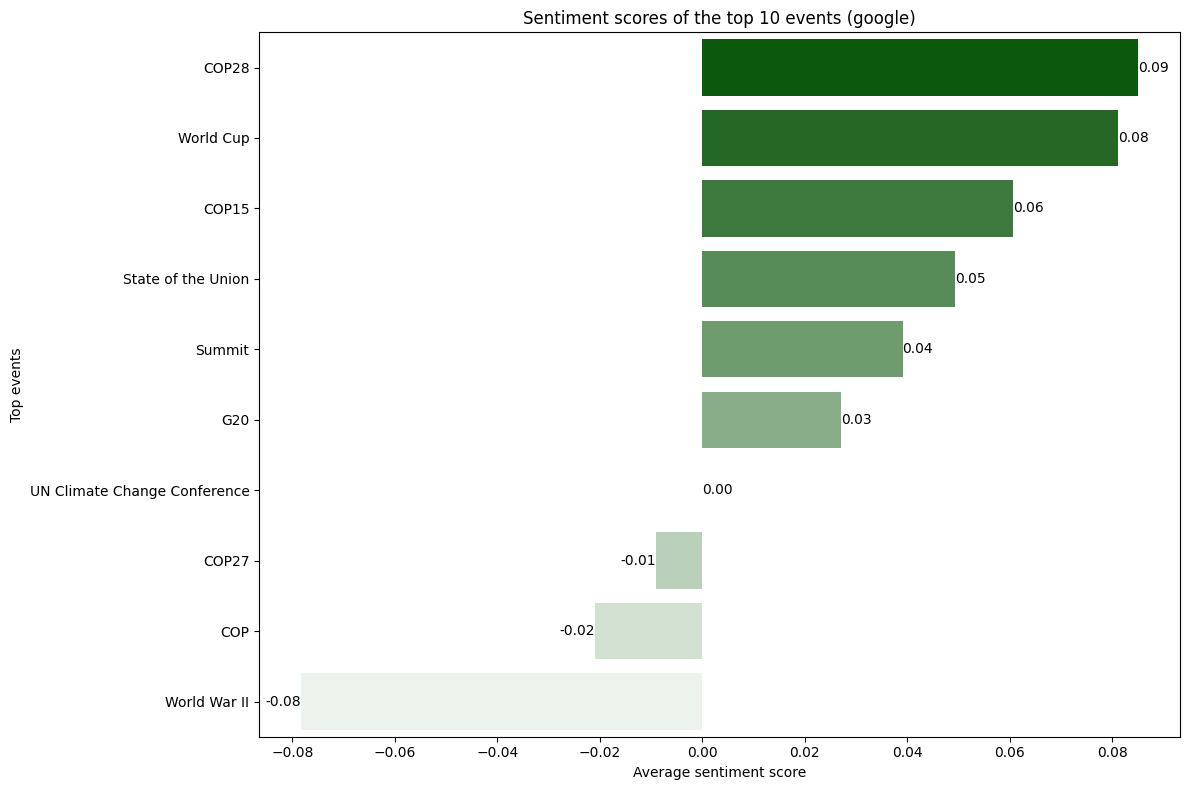

In [165]:
sentiment_plot(df,df_parag, 'event_ner_unique', "Sentiment scores of the top 10 events (google)")

In [166]:
intext_urls = df[df['text'].apply(lambda x: 'nature restoration law' in x.lower())]['url'].to_list()

{'Summit': 0.03042147485982804, 'COP15': -0.03036238426385924, 'UN Climate Change Conference': 0.0, 'COP28': 0.1397513088427092, 'State of the Union': 0.02720316718606388, 'G20': -0.1098622977733612, 'EU Green Week': 0.0, 'the Ukraine war': -0.16078877449035645, 'COP27': 0.12795951962471008, 'EU Sustainable Energy Week': 0.0}


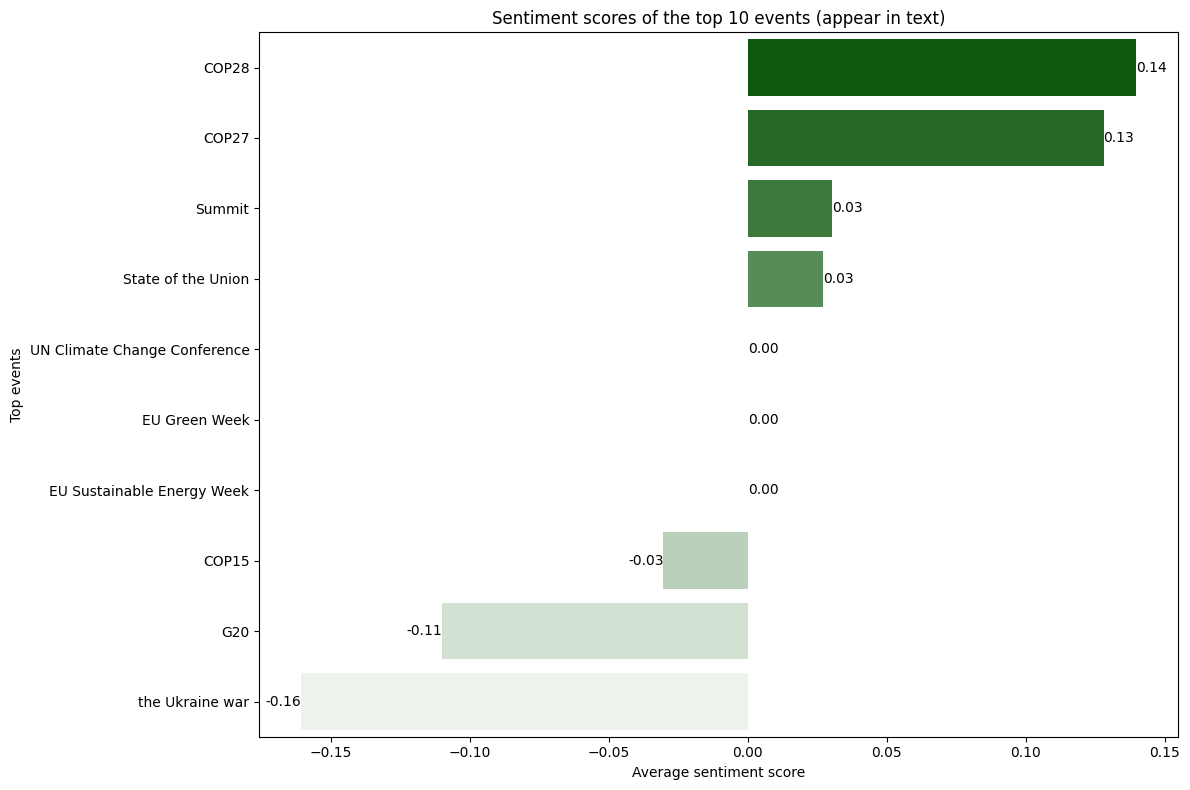

In [168]:
sentiment_plot(df[df['url'].apply(lambda x: x in intext_urls)]
               ,df_parag[df_parag['url'].apply(lambda x: x in intext_urls)]
               , 'event_ner_unique', "Sentiment scores of the top 10 events (appear in text)")

{'Ursula Von Der Leyens': 0.04602468028564156, 'Frans Timmermans': -0.010055536864906229, 'Vladimir Putin': -0.14491292897976424, 'Manfred Webers': -0.14070041536541342, 'Emmanuel Macrons': 0.0011576414477116991, 'Pascal Canfin': -0.10138255875065641, 'Joe Biden': 0.017022452799670667, 'Olaf Scholz': 0.011180303062832653, 'Maro Efovi': 0.016550809068557545, 'Josep Borrell Fontelles': -0.09857495906006576}


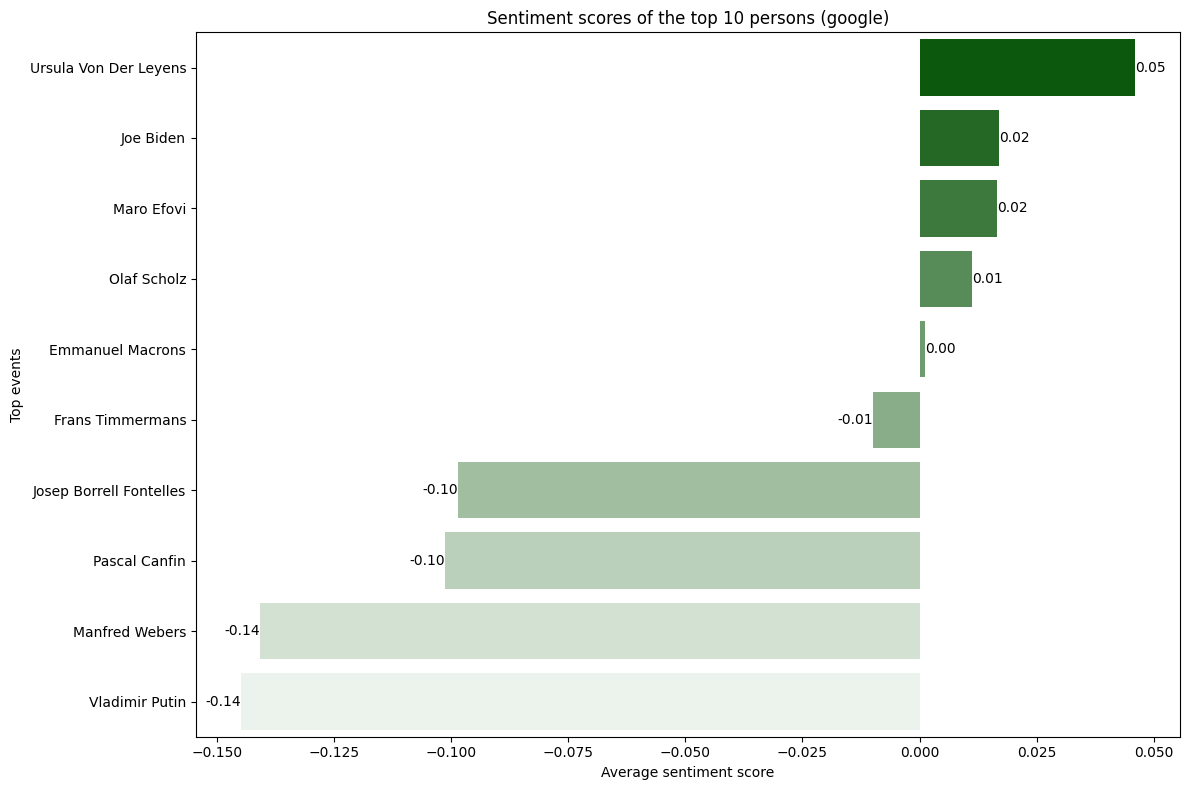

In [169]:
sentiment_plot(df,df_parag, 'persons_ner_normalized_unique', "Sentiment scores of the top 10 persons (google)")

{'Ursula Von Der Leyens': 0.0379369348546733, 'Frans Timmermans': -0.06536923176303333, 'Manfred Webers': -0.17242608734741513, 'Pascal Canfin': -0.10754870971043905, 'Maro Efovi': 0.032641972423693454, 'Emmanuel Macrons': -0.05096542888933474, 'Roberta Metsola': 0.12200917029867367, 'Csar Luena': 0.14243816309853605, 'Mark Ruttes': -0.024427737368911993, 'Virginijus Sinkeviius': 0.020895672987585198}


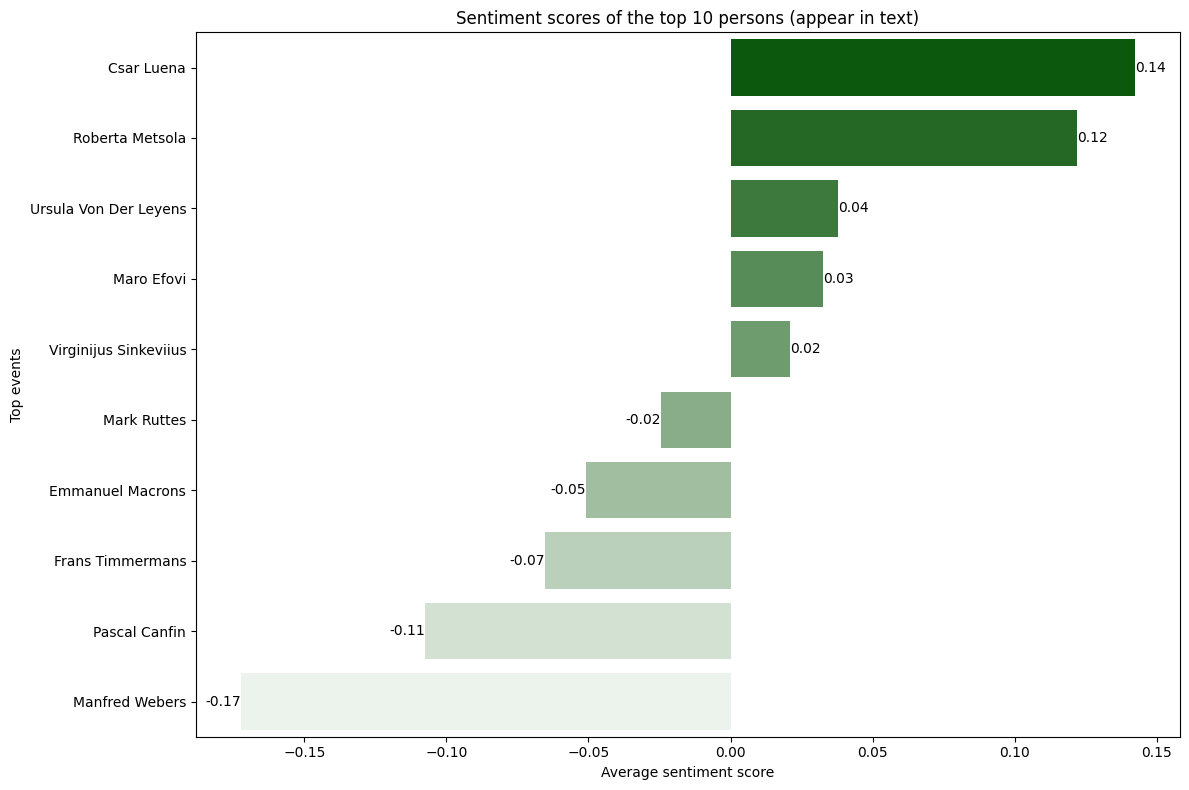

In [170]:
sentiment_plot(df[df['url'].apply(lambda x: x in intext_urls)]
               ,df_parag[df_parag['url'].apply(lambda x: x in intext_urls)]
               , 'persons_ner_normalized_unique', "Sentiment scores of the top 10 persons (appear in text)")

{'Vladimir Putin': -0.12523094443387764, 'Volodymyr Zelensky': -0.05560272323324325, 'Joe Biden': 0.033281409541765845, 'Peter Wagner': -0.18282654663411582, 'Josep Borrell Fontelles': -0.14474707727248853, 'Matthew Miller': -0.12134129267472488, 'Francis Joyon': 0.15135319639996783, 'Dmitry Peskov': -0.1580573573256984, 'Emmanuel Macrons': 0.043184112372069525, 'Xi Jinping': 0.019501021275153525}


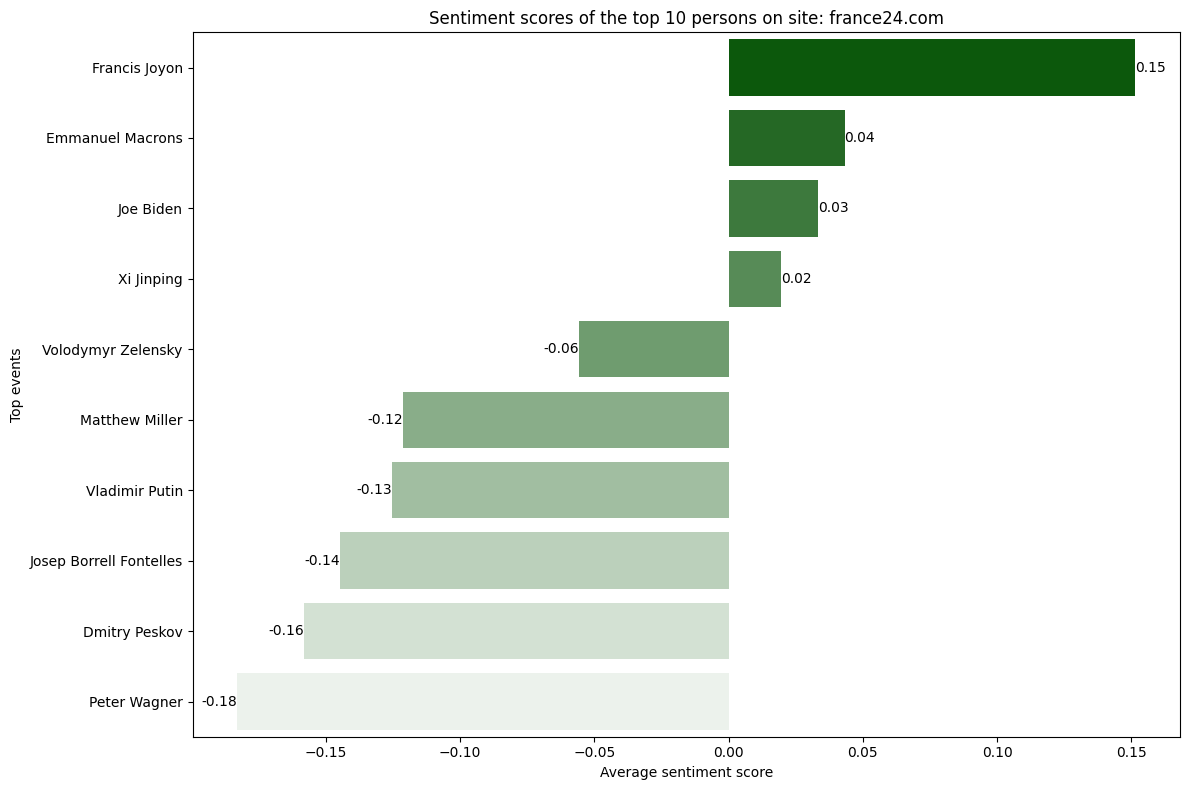

{'Ursula Von Der Leyens': 0.10111140941872317, 'Frans Timmermans': -0.0482820372689854, 'Pascal Canfin': -0.17451331545324886, 'Virginijus Sinkeviius': 0.07508637348810832, 'Greta Thunbergs': -0.1600540432063016, 'Christine Schneider': -0.44034895457719503, 'Jair Bolsonaro': -0.11550775034861131, 'Maro Efovi': 0.020323033305420273, 'Luiz Incio Lula Da Silvas': 0.0038213729858398438, 'Joe Biden': 0.0746038372700031}


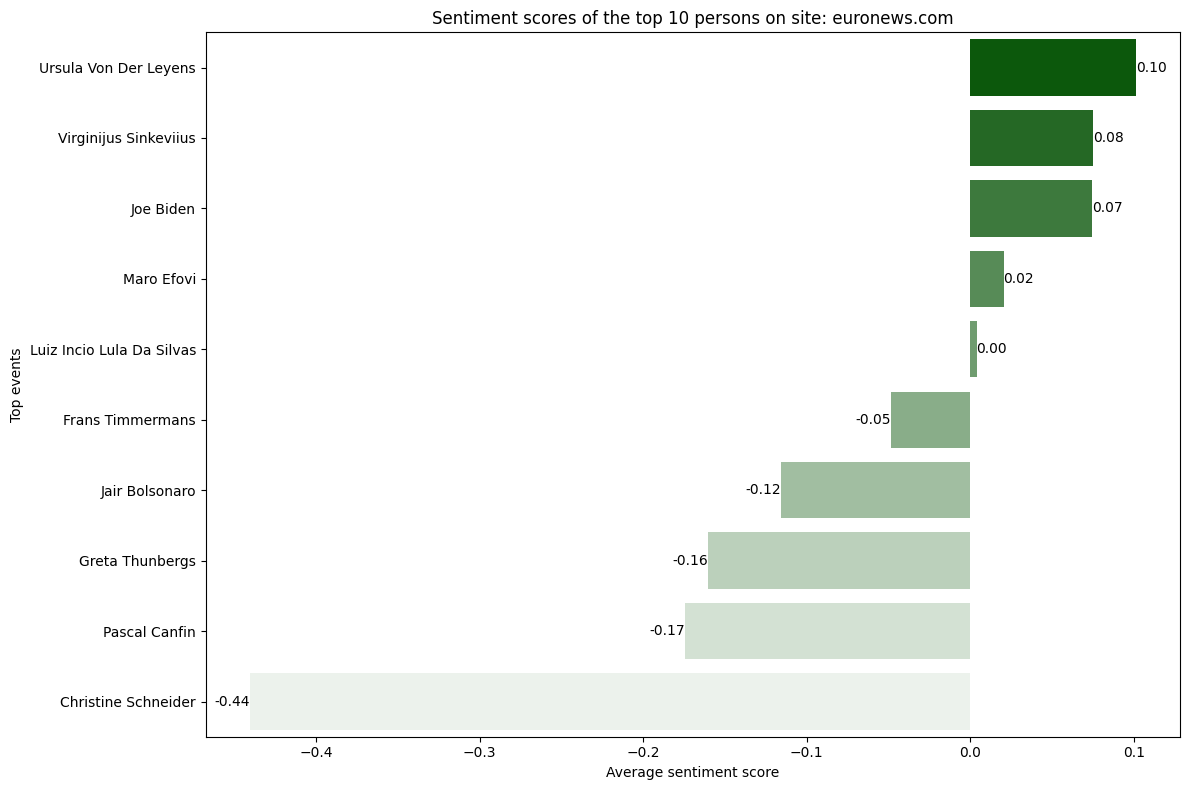

{'Ursula Von Der Leyens': -0.006013734649852867, 'Vladimir Putin': -0.17500676094217504, 'Manfred Webers': -0.16652930694021237, 'Frans Timmermans': -0.0157945916056633, 'Emmanuel Macrons': -0.062155223200681904, ' Suzanne Lynch': 0.2600719142871298, 'Olaf Scholz': -0.04907576425207986, 'Pascal Canfin': -0.19464964166693732, 'Roberta Metsola': 0.008929539451282985, 'Louise Guillot': 0.26321333730724494}


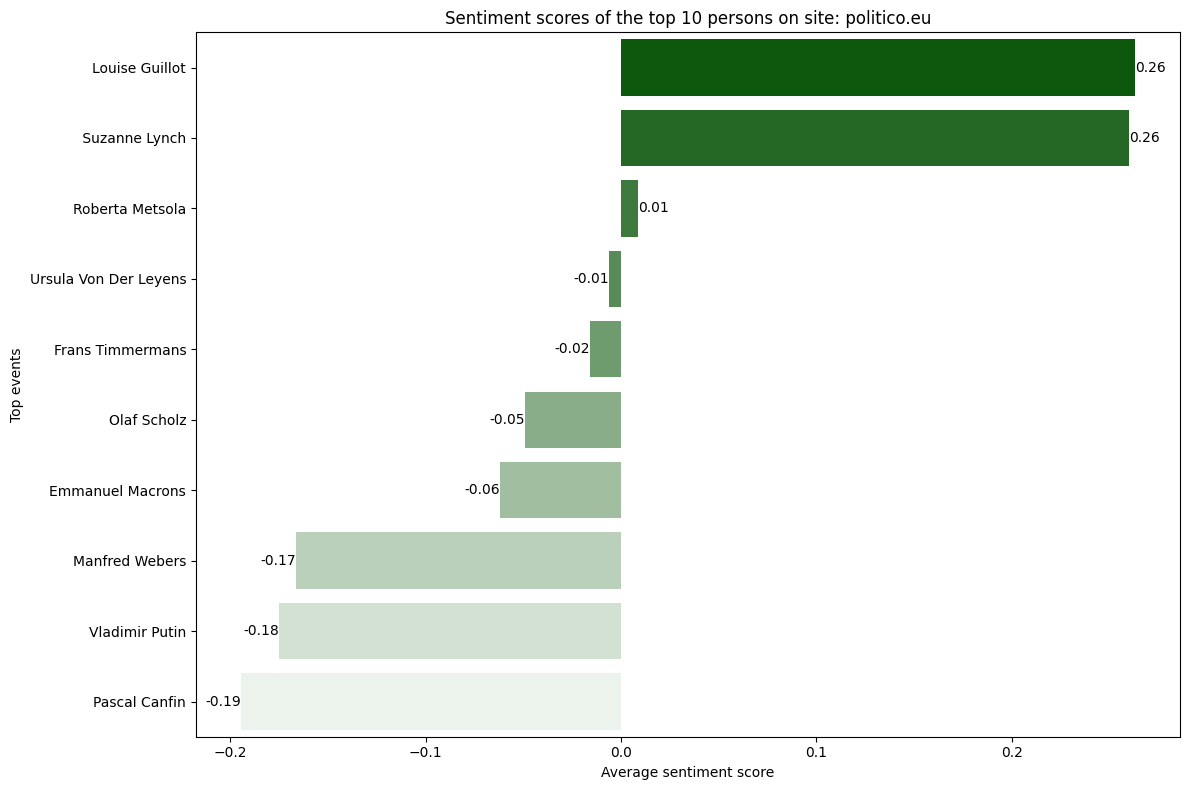

{'Mohamed Bazoum': -0.2882849944048914, 'Olaf Scholz': 0.056312109213069554, 'Vladimir Putin': -0.1696939104321328, 'Ursula Von Der Leyens': 0.10908422757437641, 'Bola Tinubu': -0.0807489647584803, 'Antonio Guterres': 0.032125853142648375, 'Josep Borrell Fontelles': -0.10673370593123965, 'Emmanuel Macrons': 0.08266818867942502, 'Joe Biden': 0.01642938522459234, 'Vikramjit Singh Rooprai': -0.28207952635628836}


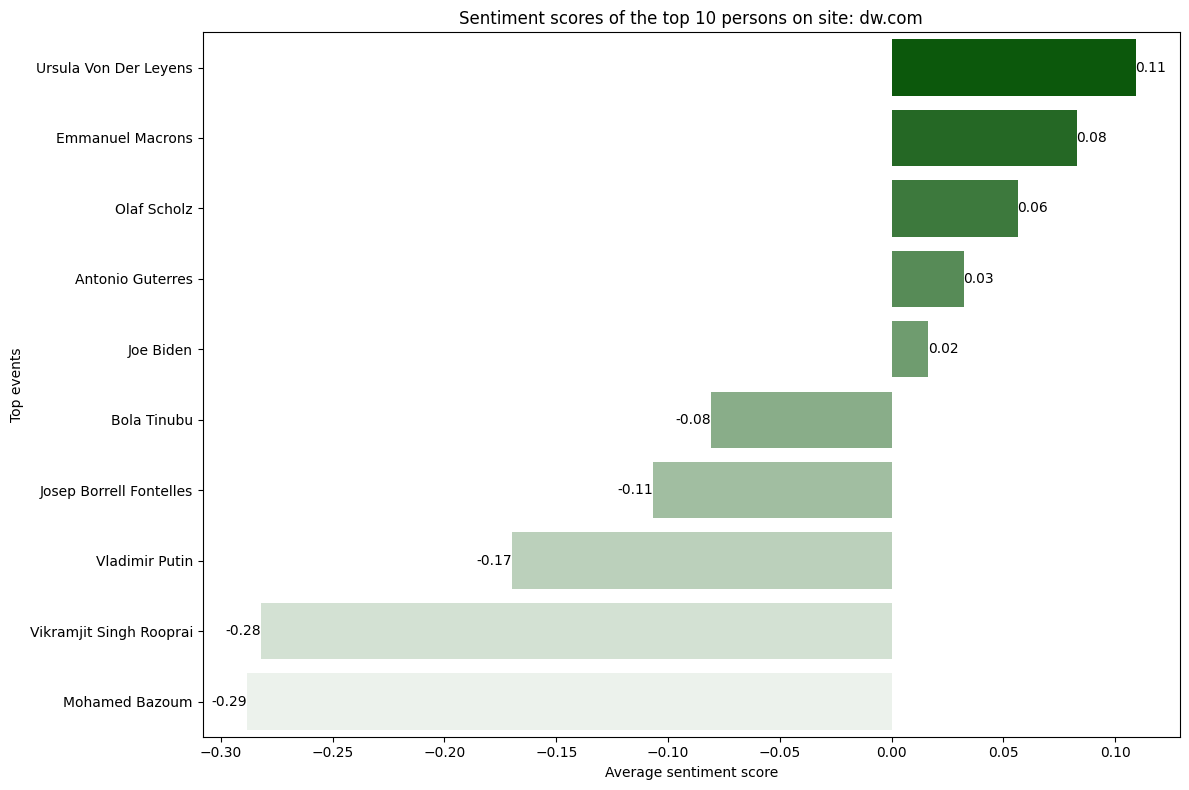

{'Frans Timmermans': -0.014424424792200791, 'Ursula Von Der Leyens': 0.05673799395874104, 'Pascal Canfin': 0.005971648626857334, 'Emmanuel Macrons': 0.0029554160603557727, 'Manfred Webers': -0.044986593127250674, ' Frdric Simon': -0.03136420468448864, 'Sarantis Michalopoulos': 0.0, 'Mark Ruttes': -0.07795859242861088, 'Maro Efovi': -0.01710935446046154, 'Csar Luena': 0.12419371352051244}


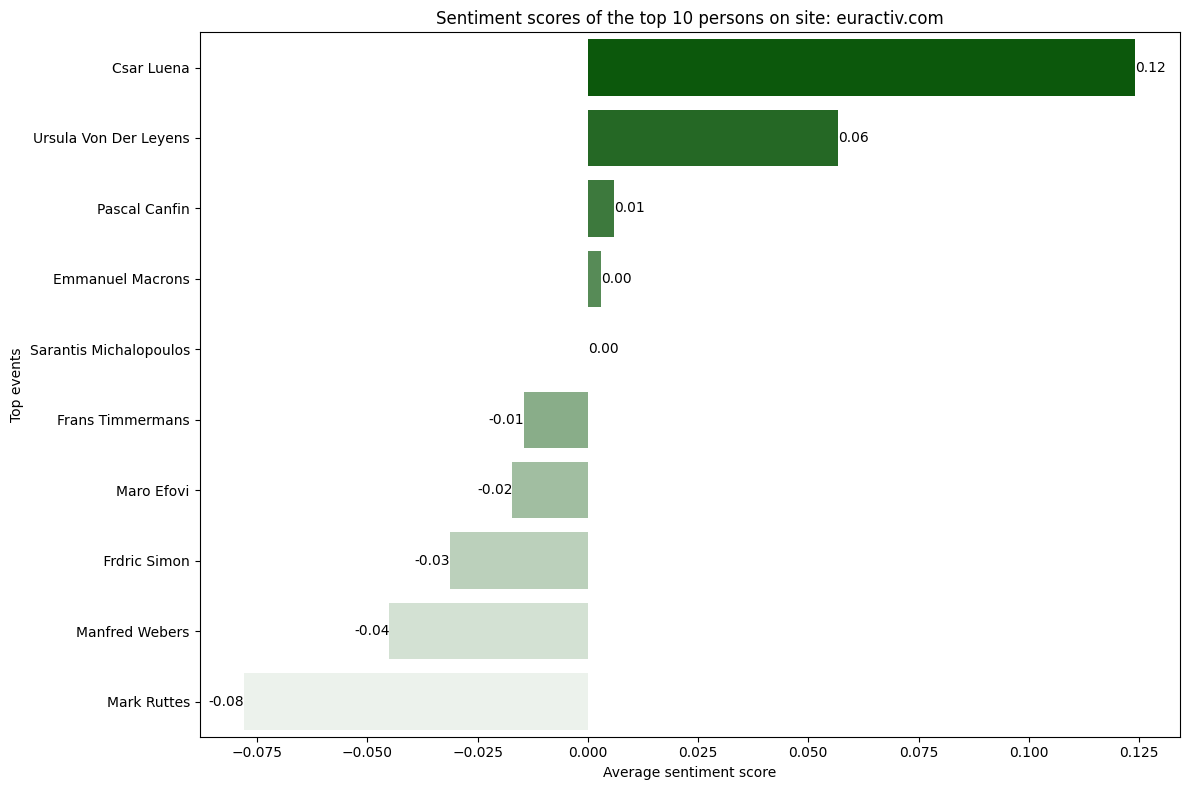

In [171]:
for site in df['site'].unique():
    sentiment_plot(df[df['site']==site],df_parag[df_parag['site']==site], 'persons_ner_normalized_unique', f"Sentiment scores of the top 10 persons on site: {site}")


{'European Union': -0.04381956067691759, 'European Commission': -0.03040851201676675, 'European Parliament': -0.05741897253100169, 'AFP': -0.08983652727005796, 'EURACTIV': 0.0013045774275149589, 'EPP': -0.15881573475042723, 'Getty Images': -0.008578811191364765, 'POLITICO': -0.006727494869438192, 'DW': -0.04798649113344337, 'UN': -0.10288303257235952}


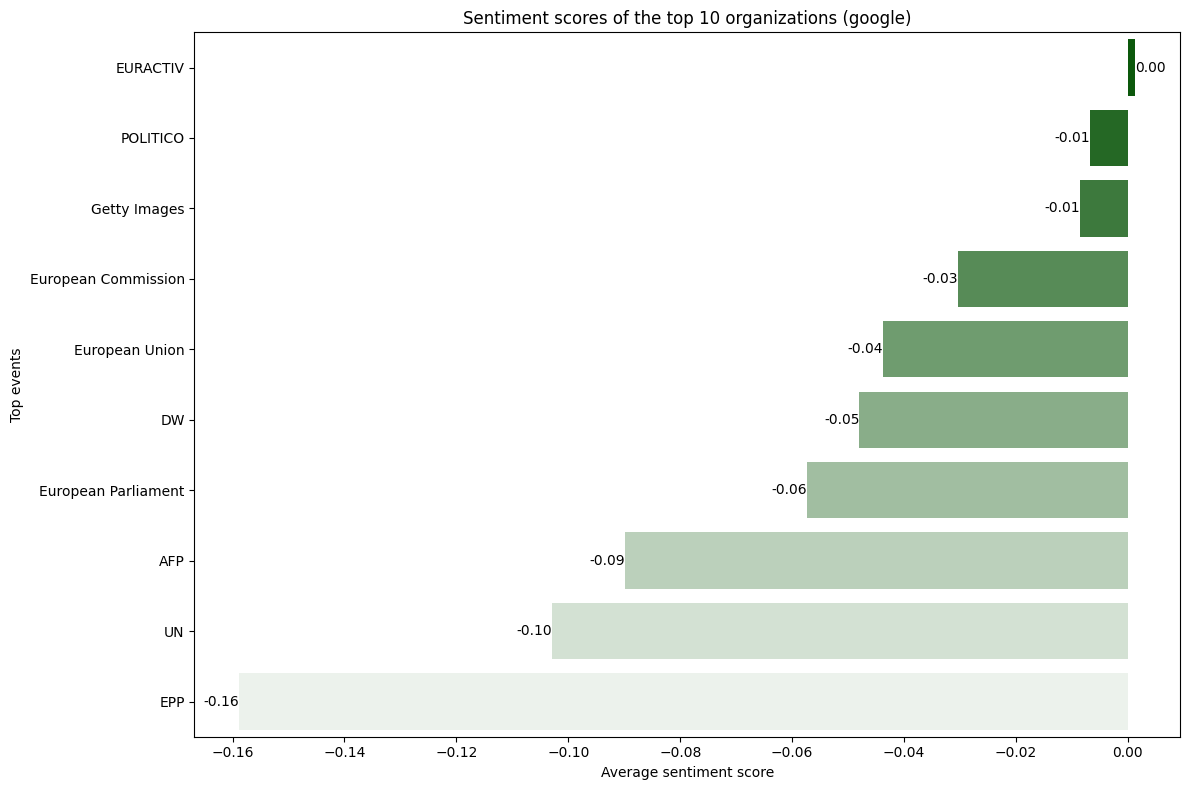

In [172]:
sentiment_plot(df,df_parag, 'org_ner_norm_unique', "Sentiment scores of the top 10 organizations (google)")

{'Ukraine': -0.13722762263989824, 'Germany': -0.052202840604362, 'EU': -0.0330322185966456, 'Brussels': -0.030993101828270517, 'Russia': -0.1799991167084829, 'France': -0.05667719346393148, 'US': -0.01738124455437718, 'Spain': -0.01909547959760468, 'China': -0.048122193387025385, 'Netherlands': -0.024783239880969428}


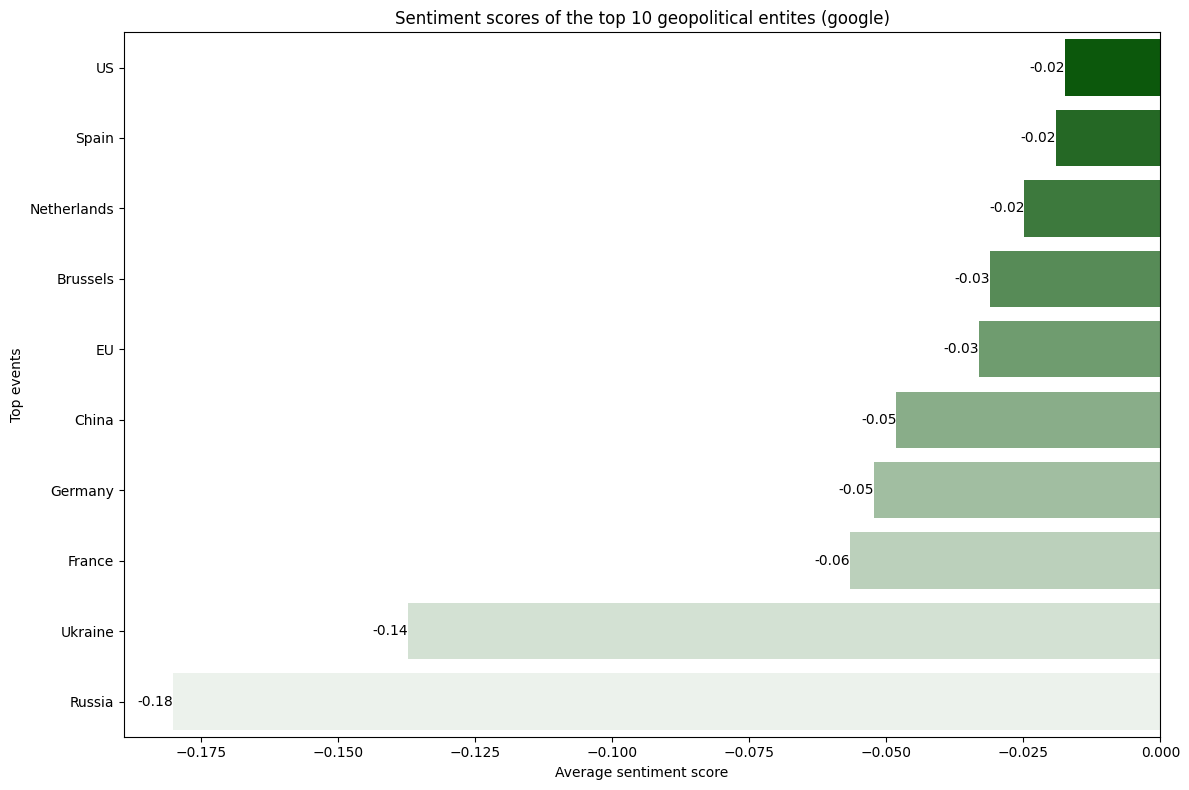

In [173]:
sentiment_plot(df,df_parag, 'gpe_ner_unique', "Sentiment scores of the top 10 geopolitical entites (google)")

{'France': -0.05116570353507996, 'US': -0.051479339776552765, 'Paris': -0.0344787004899669, 'Ukraine': -0.1434919688080029, 'Russia': -0.18472784164657244, 'the United States': -0.04335038188854646, 'Turkey': -0.11826465638721881, 'China': -0.05874822596213181, 'Washington': -0.07546598051603023, 'Moscow': -0.1784399473191013}


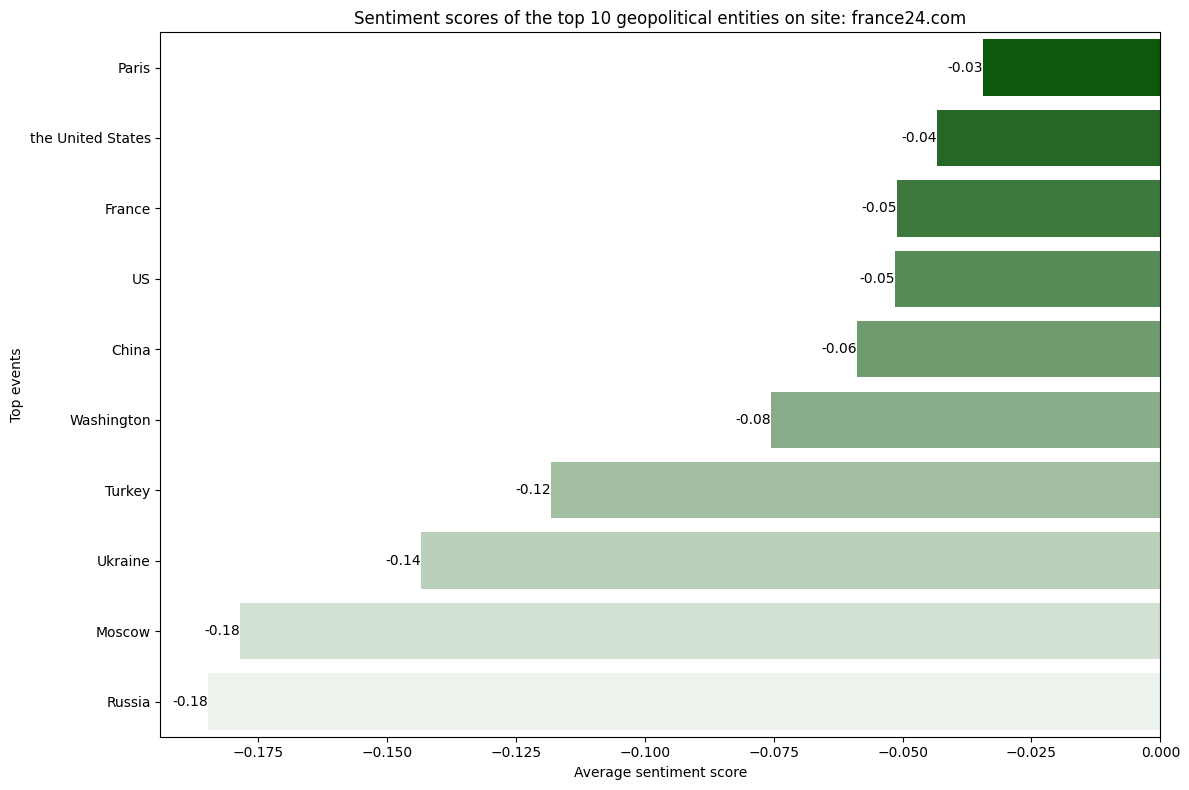

{'France': -0.05067362829640105, 'Brussels': 0.018181701579431848, 'Ukraine': -0.14832458322176514, 'US': 0.04111420851405627, 'Spain': 0.01694466747454743, 'UK': -0.015597230391612845, 'Italy': -0.08410443971046856, 'Germany': 0.020583455767553164, 'Russia': -0.22067742505349403, 'China': -0.00575629160517738}


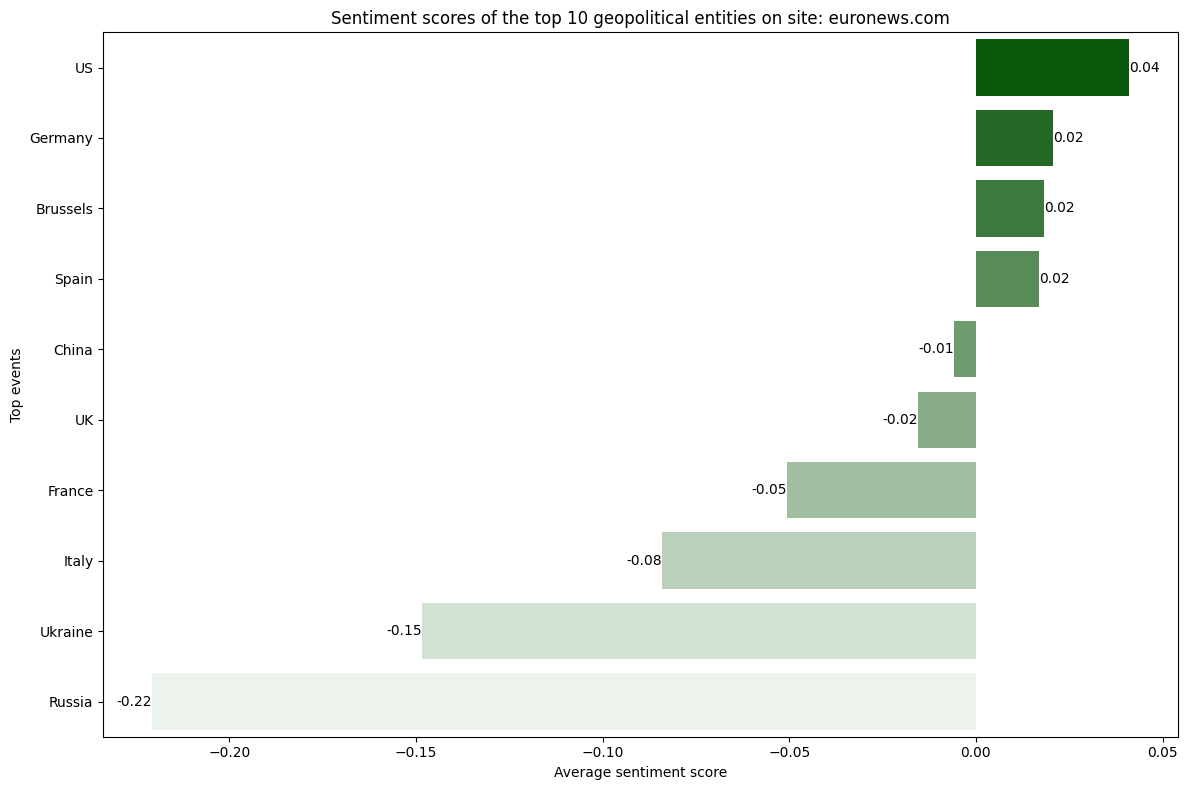

{'Ukraine': -0.13517684430897023, 'Brussels': -0.04851919748242869, 'EU': -0.04003348286065941, 'Russia': -0.1805161521873392, 'U.S.': -0.048151303561958105, 'Germany': -0.11184802517359152, 'France': -0.08640631012129507, 'U.K.': -0.037875075874181326, 'China': -0.08384934054824697, 'Netherlands': -0.08721053896591677}


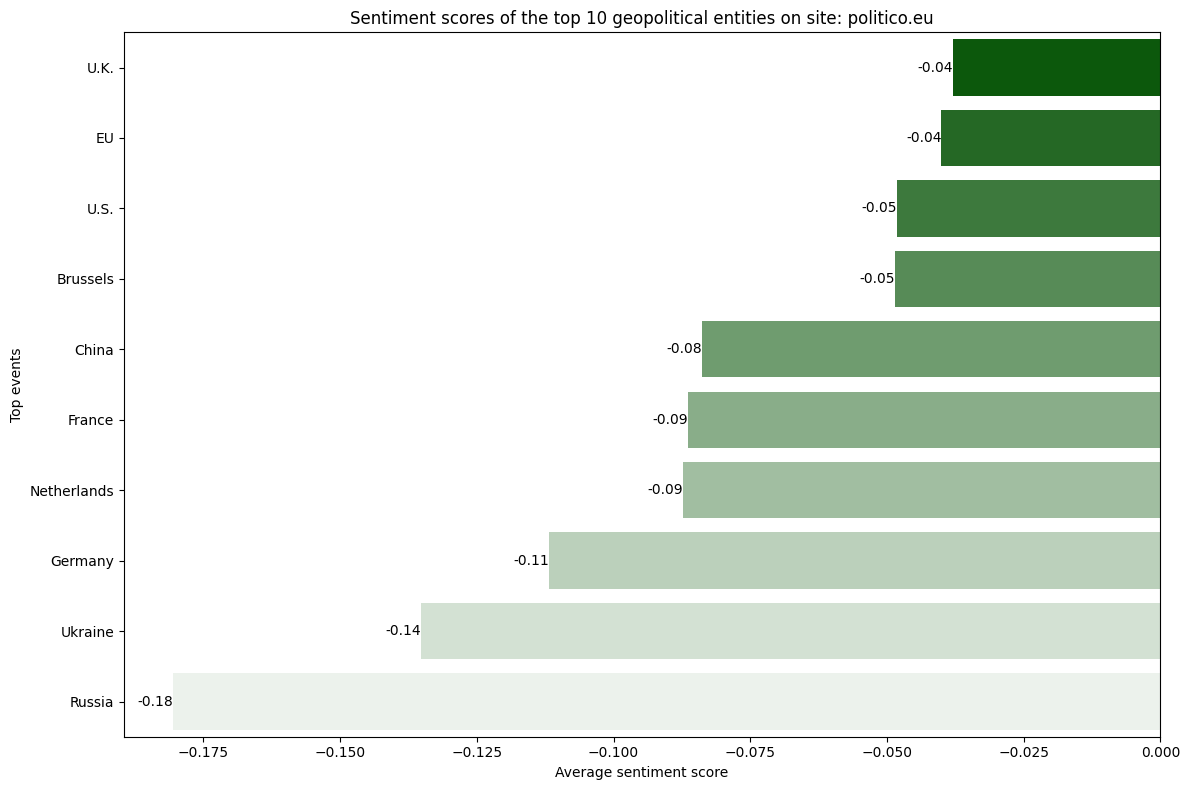

{'Germany': -0.038437172404361314, 'US': -0.04575809100659461, 'Russia': -0.1556217418978419, 'Ukraine': -0.1298748391694511, 'India': 0.026137363539928453, 'China': -0.031395885651606885, 'Japan': -0.04981177834903493, 'France': -0.023502172937818394, 'EU': -0.03864328907086299, 'Poland': -0.0940834219041078}


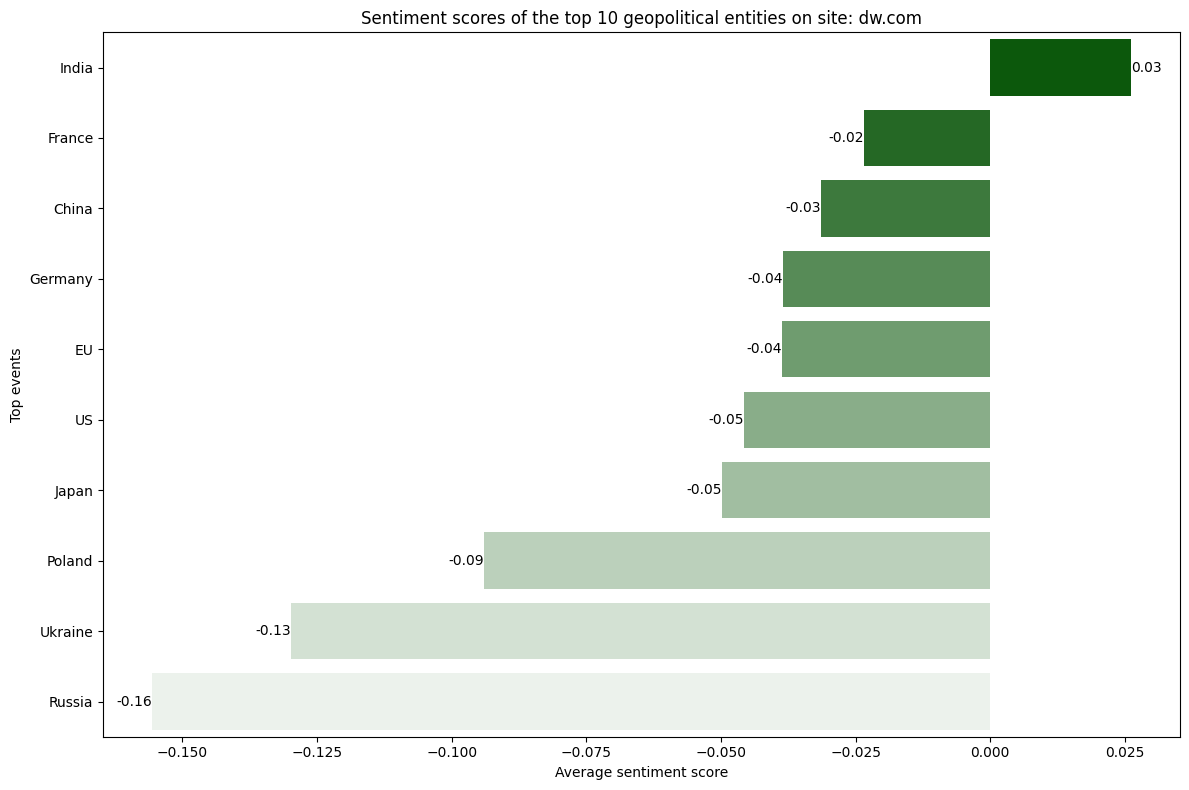

{'EU': -0.02606050173441569, 'Brussels': -0.0038131577827636375, 'Ukraine': -0.12964282071151914, 'Germany': -0.05241377657724296, 'France': -0.05319348055046874, 'Spain': -0.008038982005304418, 'Italy': -0.06876670778595467, 'Russia': -0.19631472113898468, 'Austria': -0.11617463918832632, 'Poland': -0.08528810956502918}


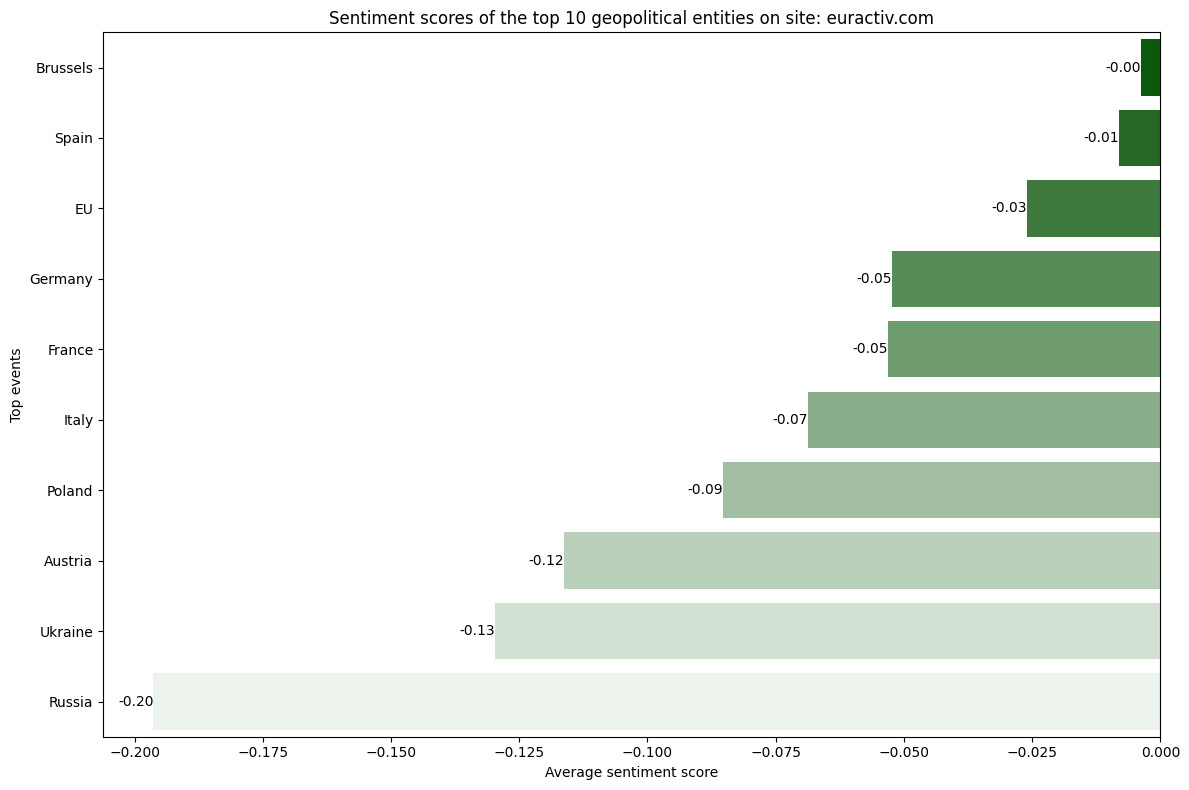

In [174]:
for site in df['site'].unique():
    sentiment_plot(df[df['site']==site],df_parag[df_parag['site']==site], 'gpe_ner_unique', f"Sentiment scores of the top 10 geopolitical entities on site: {site}")
